---

# **Risk Analytics – Data Science Take Home Assignment**

## **Data Scientist Profile**

**Name:** Hijir Della Wirasti
**Role:** Data Scientist
* **LinkedIn:** [linkedin.com/in/hijirdella](https://www.linkedin.com/in/hijirdella/)
* **GitHub:** [github.com/hijirdella](https://github.com/hijirdella)
* **Portfolio Website:** [hijirdata.com](https://www.hijirdata.com/)
* **Email:** [hijirdw@gmail.com](mailto:hijirdw@gmail.com)
* **Project Repository:** [github.com/hijirdella/Credit-Scoring-Default-Prediction-Dashboard](https://github.com/hijirdella/Credit-Scoring-Default-Prediction-Dashboard)
* **Deployed App (Streamlit):** [credit-scoring-default-prediction-dashboard.streamlit.app](https://credit-scoring-default-prediction-dashboard.streamlit.app/)
* **Raw Data for App:** [combined_df.csv](https://github.com/hijirdella/Credit-Scoring-Default-Prediction-Dashboard/blob/main/combined_df.csv)
* **Youtube Video:** [How to Use the Credit Scoring Default Prediction App for Business Teams](https://www.youtube.com/watch?v=xZrQO7R4OsQ)

---

# Welcome to the Risk Analytics Data Science Take Home Assignment

Risk Analytics provides virtual credit limits to it's customers to meet a wide array of customer financing needs. We have provided you with some data related to our customer's loan applications, loan details and their repayment history.

Risk Analytics wants to use this data to improve their risk management, and asks you to use your Data Science skills to derive valuable insights from the data and to build a predictive credit score model to aid in future customer credit decisions.

**Requirements:**
1. You have 7 days to report on the assignment
2. Please use python to solve this exercise. You can use libraries such as: sqlalchemy, pandas, or any other packages of your choice that can help you work on the assignments
3. For visualizations, please use python and its common libraries
4. When you are prompted to use sql, please use sqlalchemy for that assignment

**Deliverables:**
1. Python Jupyter notebook with your code (please comment the code! this let us follow your thought process)
2. In addition, also save your notebooks in .html file and attach it with the actual code

**What are we looking for:**
1. Story from the data (Completeness of analysis/ story)
2. There is no right solution to this assignment
3. Your thought process (Be precise, straight to the point, and remember to comment the code)
4. The rationale behind the decisions you made (Provide justifications to your recommendations)

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa
path = 'data/'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

We have already prepared a database for you to query from

In [3]:
 # Create SQL Alchemy Engine
engine = sa.create_engine('sqlite:///database.db')

In [4]:
# Import data as pd.DataFrame
application_df = pd.read_csv(path + 'application.csv')
loan_df = pd.read_csv(path + 'loan.csv')
payment1_df = pd.read_csv(path + 'payment1.csv')
payment2_df = pd.read_csv(path + 'payment2.csv')

In [5]:
# Insert data from pd.DataFrame to SQL Alchemy Engine
application_df.to_sql(name='application', con=engine,if_exists='replace')
loan_df.to_sql(name='loan', con=engine,if_exists='replace')
payment1_df.to_sql(name='payment1', con=engine,if_exists='replace')
payment2_df.to_sql(name='payment2', con=engine,if_exists='replace')

17911

In [6]:
# Works with SQLAlchemy 2.x
from sqlalchemy import text

def query_from_db(sql_long_string, engine, params=None):
    """
    Execute SQL statement and return the result as a pandas DataFrame.
    Compatible with SQLAlchemy 2.x (explicit connection).
    """
    with engine.connect() as conn:
        df = pd.read_sql_query(text(sql_long_string), conn, params=params)
    return df


In [7]:
query_from_db

<function __main__.query_from_db(sql_long_string, engine, params=None)>

### Assignment 1 - Data Preparation and Cleaning

Please do all these tasks in SQL query.
1. Combine all the tables into a single dataframe.
2. Do you notice anything suspicious with the dataframe? If yes, please do a preliminary analysis and fix it. Explain what you found and how you fix it.
3. Do you see any outliers? Explain how do you detect the outlier and how you fix it.
4. Provide your assumptions on the data.

#### 1. Combine all the tables into a single dataframe.

**Explanation:**<br>
1️. Combine payment1 and payment2 first into "all_payments" using UNION ALL<br>
2️. Then join only once to loan using loan_id<br>
3️. Join application to loan using application_id<br>
**=> avoids row duplication caused by two payment joins**

In [8]:
# 1️. SQL QUERY: Combine all tables into one clean dataset
# Thought process:
# - The goal is to create a unified dataset containing application, loan, and payment details.
# - payment1 and payment2 have overlapping structure → use UNION (not UNION ALL) to avoid duplicate records.
# - Join logic:
#     application  ←→  loan   (via application_id)
#     loan         ←→  payment (via loan_id)
# - LEFT JOIN is used to keep all application records even if no payment yet (active loans).


sql = """
WITH all_payments AS (
    SELECT payment_id, due_date, paid_date, paid_amount, dpd, loan_id
    FROM payment1
    UNION            -- removes duplicate payments between payment1 & payment2
    SELECT payment_id, due_date, paid_date, paid_amount, dpd, loan_id
    FROM payment2
)
SELECT
    a.*,             -- all customer/application-level attributes
    l.loan_id,
    l.loan_amount,
    l.loan_duration,
    l.installment_amount,
    l.fund_transfer_ts,
    p.payment_id,
    p.due_date,
    p.paid_date,
    p.paid_amount,
    p.dpd
FROM application a
LEFT JOIN loan l
    ON a.application_id = l.application_id
LEFT JOIN all_payments p
    ON l.loan_id = p.loan_id;
"""


# 2️. EXECUTE QUERY using helper function
# - query_from_db() safely executes SQL using SQLAlchemy 2.x syntax.
# - Returns a pandas DataFrame for easy manipulation & inspection.
combined_df = query_from_db(sql, engine)


# 3️. CLEAN-UP: Remove redundant columns (index, Unnamed)
# - CSV or SQL exports often contain extra index/Unnamed columns → drop them for clarity.
combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed|index$', case=False)]


# 4️. DISPLAY RESULTS
# - Show all columns in the head() preview without truncation.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

combined_df.head()

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,job_industry,loan_id,loan_amount,loan_duration,installment_amount,fund_transfer_ts,payment_id,due_date,paid_date,paid_amount,dpd
0,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2.005021e+12,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2021-03-02,2021-04-02,149000.0,31.0
1,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2.005021e+12,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2021-04-02,2021-05-16,195000.0,44.0
2,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2.005021e+12,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2021-05-02,2021-05-30,140000.0,28.0
3,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2.005021e+12,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,2021-06-02,2021-07-06,140000.0,34.0
4,2021-01-07 13:45:43.876693+00:00,2004025695250,2.003024e+12,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2.005021e+12,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2.006022e+12,None,2021-08-02,140000.0,NaN


##### Preliminary data check & cleaning

In [9]:
# 1️. Basic info to understand data types and missingness
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16954 entries, 0 to 16953
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cdate               15143 non-null  object 
 1   application_id      16954 non-null  int64  
 2   customer_id         15159 non-null  float64
 3   loan_purpose        15047 non-null  object 
 4   loan_purpose_desc   15381 non-null  object 
 5   dob                 15553 non-null  object 
 6   address_provinsi    15276 non-null  object 
 7   marital_status      14976 non-null  object 
 8   dependent           14937 non-null  float64
 9   job_type            15259 non-null  object 
 10  job_industry        15580 non-null  object 
 11  loan_id             16866 non-null  float64
 12  loan_amount         16624 non-null  float64
 13  loan_duration       16609 non-null  float64
 14  installment_amount  16580 non-null  float64
 15  fund_transfer_ts    16598 non-null  object 
 16  paym

---

### **Data Types & Structure**

* Identifier columns (`application_id`, `loan_id`, `customer_id`) are stored as numeric values but should be converted to **string** to preserve precision and avoid scientific notation.
* Date fields (`cdate`, `dob`, `fund_transfer_ts`, `due_date`, `paid_date`) are currently text and should be converted to **datetime** for time-based analysis (e.g., age, loan duration, payment delay).

**Insight:**
Proper data-type conversion will enable accurate calculations for customer age, loan age, and repayment timing.

---

In [10]:
# 1️. CONVERT DATE-TIME COLUMNS WITH TIMEZONE (UTC)
# Thought process:
# - 'cdate' and 'fund_transfer_ts' are system timestamps → usually stored in UTC.
# - Use utc=True so they become timezone-aware (consistent for time-diff calculations).
# - errors='coerce' → invalid formats become NaT instead of raising errors.

tz_cols = ['cdate', 'fund_transfer_ts']
for col in tz_cols:
    if col in combined_df.columns:  # safe check in case column is missing
        combined_df[col] = pd.to_datetime(
            combined_df[col],
            errors='coerce',  # invalid strings → NaT
            utc=True          # store as UTC-based datetime
        )


# 2️. CONVERT PURE DATE COLUMNS (NO TIMEZONE)
# Thought process:
# - 'dob', 'due_date', 'paid_date' represent calendar dates, not timestamps.
# - No timezone needed; local date context is enough for age, DPD, and overdue calculations.
# - errors='coerce' keeps pipeline robust when encountering dirty values.

date_cols = ['dob', 'due_date', 'paid_date']
for col in date_cols:
    if col in combined_df.columns:  # only convert if the column exists
        combined_df[col] = pd.to_datetime(
            combined_df[col],
            errors='coerce'  # invalid values → NaT
        )


In [11]:
# STANDARDIZE IDENTIFIER COLUMNS AS STRING
# Thought process:
# - IDs ('application_id', 'customer_id', 'loan_id', 'payment_id') are identifiers, not numeric measures.
#   1) Try to cast to numeric → to clean obvious non-numeric junk (invalid → NaN).
#   2) Use Int64 (pandas nullable integer) → preserves missing as <NA>.
#   3) Convert to string dtype → ensures consistent type for joins / exports.
#   4) Replace literal '<NA>' strings back to proper missing value (pd.NA).

id_cols = ['application_id', 'customer_id', 'loan_id', 'payment_id']

for col in id_cols:
    if col in combined_df.columns:  # guard in case some ID columns don't exist
        combined_df[col] = (
            pd.to_numeric(combined_df[col], errors='coerce')  # invalid → NaN
            .astype('Int64')                                  # keep missing as <NA>
            .astype('string')                                 # final type: string
        )
        # Ensure missing values are stored as pd.NA, not the literal text '<NA>'
        combined_df[col] = combined_df[col].replace('<NA>', pd.NA)

In [12]:
# CONVERT DPD (Days Past Due) TO INTEGER TYPE
# Thought process:
# - 'dpd' represents count of overdue days → should be integer, not float/string.
# - Use pd.to_numeric() to clean invalid entries (errors='coerce' → NaN for invalids).
# - round() handles small decimal artifacts (e.g., 29.9 → 30).
# - Int64 dtype keeps missing values (<NA>) safely instead of forcing 0.

if 'dpd' in combined_df.columns:
    combined_df['dpd'] = (
        pd.to_numeric(combined_df['dpd'], errors='coerce')  # invalid → NaN
        .round()                                            # fix float decimals
        .astype('Int64')                                    # nullable integer type
    )

In [13]:
combined_df.head()

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,job_industry,loan_id,loan_amount,loan_duration,installment_amount,fund_transfer_ts,payment_id,due_date,paid_date,paid_amount,dpd
0,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009983,2021-03-02,2021-04-02,149000.0,31
1,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009984,2021-04-02,2021-05-16,195000.0,44
2,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009985,2021-05-02,2021-05-30,140000.0,28
3,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009986,2021-06-02,2021-07-06,140000.0,34
4,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009987,NaT,2021-08-02,140000.0,<NA>


In [14]:
# Save to SQLite as table 'combined' 
combined_df.to_sql('combined', con=engine, if_exists='replace', index=False)
print("Table 'combined' has been successfully created in the SQLite database.")

Table 'combined' has been successfully created in the SQLite database.


In [15]:
# Save to CSV
combined_df.to_csv("combined_df.csv", index=False)

print("File berhasil disimpan sebagai 'combined_df.csv'")
## raw data ini akan digunakan untuk tes model terbaik

File berhasil disimpan sebagai 'combined_df.csv'


In [16]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16954 entries, 0 to 16953
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   cdate               15143 non-null  datetime64[ns, UTC]
 1   application_id      16954 non-null  string             
 2   customer_id         15159 non-null  string             
 3   loan_purpose        15047 non-null  object             
 4   loan_purpose_desc   15381 non-null  object             
 5   dob                 15553 non-null  datetime64[ns]     
 6   address_provinsi    15276 non-null  object             
 7   marital_status      14976 non-null  object             
 8   dependent           14937 non-null  float64            
 9   job_type            15259 non-null  object             
 10  job_industry        15580 non-null  object             
 11  loan_id             16866 non-null  string             
 12  loan_amount         16624 non-nu

##### Check and remove duplicated rows

In [17]:
# Check and remove duplicated rows
dup_before = combined_df.duplicated().sum()
print(f"Number of duplicated rows before cleaning: {dup_before}")

# Drop exact duplicate rows
combined_df = combined_df.drop_duplicates()

# Verify after cleaning
dup_after = combined_df.duplicated().sum()
print(f"Number of duplicated rows after cleaning: {dup_after}")
print(f"Final number of rows: {len(combined_df)}")

Number of duplicated rows before cleaning: 0
Number of duplicated rows after cleaning: 0
Final number of rows: 16954


##### Statistical Summary 

In [18]:
# Numeric summary
print("\n Numeric columns summary:\n")
display(combined_df.describe().transpose())


 Numeric columns summary:



,count,mean,min,25%,50%,75%,max,std
dob,15553,1988-09-12 23:02:46.887417216,1962-03-08 00:00:00,1984-04-08 00:00:00,1989-07-08 00:00:00,1994-01-27 00:00:00,2000-09-12 00:00:00,NaN
dependent,14937.0,1.121376,0.0,0.0,1.0,2.0,5.0,1.106808
loan_amount,16624.0,1632131.748316,8061.0,323000.0,700000.0,2000000.0,18000000.0,2270782.687463
loan_duration,16609.0,4.779577,1.0,3.0,5.0,6.0,9.0,2.249599
installment_amount,16580.0,379698.168637,8888.0,113000.0,201000.0,483000.0,3360000.0,436114.349927
due_date,16476,2021-12-07 20:06:22.811362048,2021-01-01 00:00:00,2021-09-27 00:00:00,2021-12-12 00:00:00,2022-02-28 00:00:00,2022-11-09 00:00:00,NaN
paid_date,11471,2021-11-06 17:43:46.484177408,2021-01-29 00:00:00,2021-09-02 00:00:00,2021-11-25 00:00:00,2022-01-23 00:00:00,2022-03-16 00:00:00,NaN
paid_amount,16497.0,246478.961205,0.0,0.0,113000.0,289000.0,3776000.0,385735.113918
dpd,11205.0,11.783936,-230.0,6.0,26.0,29.0,236.0,33.175598


In [19]:
# Categorical summary
print("\n Categorical columns summary:\n")
display(combined_df.describe(include=['object', 'string']).transpose())


 Categorical columns summary:



,count,unique,top,freq
application_id,16954,497,2004025892645,682
customer_id,15159,451,2003020680474,682
loan_purpose,15047,11,Modal usaha,5060
loan_purpose_desc,15381,442,menambah modal untuk usaha semakin maju dan berkembang,682
address_provinsi,15276,32,Jawa Barat,4225
marital_status,14976,4,Menikah,9395
job_type,15259,5,Pegawai swasta,13772
job_industry,15580,16,Pabrik / Gudang,3106
loan_id,16866,5024,2005020858603,20
payment_id,16852,16852,2006022009987,1


#### Check Missing Values

In [20]:
# 1️. CHECK MISSING VALUES ACROSS ALL COLUMNS (SQL)
# Thought process:
# - Goal: summarize missing values (NULLs) for every column in 'combined' table.
# - Approach: use SQL CTE to calculate both total rows and per-column missing counts.
# - Then compute missing percentage per column = (missing_count / total_rows * 100).
# - UNION ALL used to stack results vertically (one row per column).

sql_missing_summary = """
WITH total AS (
    -- Count total number of rows in the dataset
    SELECT COUNT(*) AS total_rows FROM combined
),
missing AS (
    -- For each column, count how many NULL (missing) values exist
    SELECT 'cdate' AS column_name, SUM(CASE WHEN cdate IS NULL THEN 1 ELSE 0 END) AS missing_count FROM combined
    UNION ALL SELECT 'application_id',     SUM(CASE WHEN application_id IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'customer_id',        SUM(CASE WHEN customer_id IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'loan_purpose',       SUM(CASE WHEN loan_purpose IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'loan_purpose_desc',  SUM(CASE WHEN loan_purpose_desc IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'dob',                SUM(CASE WHEN dob IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'address_provinsi',   SUM(CASE WHEN address_provinsi IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'marital_status',     SUM(CASE WHEN marital_status IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'dependent',          SUM(CASE WHEN dependent IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'job_type',           SUM(CASE WHEN job_type IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'job_industry',       SUM(CASE WHEN job_industry IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'loan_id',            SUM(CASE WHEN loan_id IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'loan_amount',        SUM(CASE WHEN loan_amount IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'loan_duration',      SUM(CASE WHEN loan_duration IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'installment_amount', SUM(CASE WHEN installment_amount IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'fund_transfer_ts',   SUM(CASE WHEN fund_transfer_ts IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'payment_id',         SUM(CASE WHEN payment_id IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'due_date',           SUM(CASE WHEN due_date IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'paid_date',          SUM(CASE WHEN paid_date IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'paid_amount',        SUM(CASE WHEN paid_amount IS NULL THEN 1 ELSE 0 END) FROM combined
    UNION ALL SELECT 'dpd',                SUM(CASE WHEN dpd IS NULL THEN 1 ELSE 0 END) FROM combined
)
-- Combine missing counts with total row count to calculate missing percentages
SELECT
    m.column_name,
    m.missing_count,
    t.total_rows,
    ROUND(100.0 * m.missing_count / t.total_rows, 2) AS missing_percent
FROM missing m, total t
ORDER BY missing_percent DESC;  -- show columns with highest missing first
"""

# 2️. EXECUTE SQL QUERY AND DISPLAY SUMMARY
# - query_from_db() safely executes SQL using SQLAlchemy engine and returns a DataFrame.
# - display() allows clean viewing of missing summary in Jupyter.
missing_summary_df = query_from_db(sql_missing_summary, engine)
display(missing_summary_df)

,column_name,missing_count,total_rows,missing_percent
0,dpd,5749,16954,33.91
1,paid_date,5483,16954,32.34
2,dependent,2017,16954,11.90
3,marital_status,1978,16954,11.67
4,loan_purpose,1907,16954,11.25
5,cdate,1811,16954,10.68
6,customer_id,1795,16954,10.59
7,job_type,1695,16954,10.00
8,address_provinsi,1678,16954,9.90
9,loan_purpose_desc,1573,16954,9.28


In [21]:
# Identify paid_date before due_date (early payments)
early_payments = combined_df[combined_df['paid_date'] < combined_df['due_date']]
print(f"Early payments detected: {len(early_payments)} rows")

Early payments detected: 2422 rows


#### 2a. Suspicious Findings (Data Quality Issues)

---

#### **Preliminary Data Review**

The combined dataset contains **16,954 rows** and **21 columns**, with a mix of application, loan, and payment information.
Data types were correctly assigned (dates, numerics, strings).

Missing value inspection shows several columns with notable null percentages (up to ~34%), especially in payment-related and customer demographic fields.

---

#### **Key Findings & Interpretation**

| **Issue Category**          | **Field(s)**                                                            | **Observation**                                                                        | **Interpretation / Business Context**                                                                                  |
| --------------------------- | ----------------------------------------------------------------------- | -------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------- |
| **Missing Values**          | `dpd` (33.9%), `paid_date` (32.3%), `dependent`, `marital_status`, etc. | Moderate to high missingness in payment-related columns                                | Expected — these records likely represent **active or not-yet-due loans** rather than data loss.                       |
| **Repeated Identifiers**    | `application_id`, `customer_id`, `loan_id`, `payment_id`                | IDs appear multiple times across records                                               | ✅ Not a data error. Reflects **one-to-many relationships** (one customer → multiple applications → multiple payments). |
| **Negative DPD Values**     | `dpd` min = -230 days                                                   | Normally suspicious, but here it represents **early payments** (paid before due date). | 2,422 rows were identified as early payments — retained for analysis with flag `dpd < 0`.                              |
| **Outliers**                | `loan_amount` up to 18,000,000; `paid_amount` up to 3,776,000           | Large range and high standard deviation                                                | Expected variability across loan sizes. Will handle later via **scaling or capping** for modeling.                     |
| **Demographic Missingness** | `dob`, `dependent`, `marital_status`, `address_provinsi`                | Missing 8–12% of records                                                               | Likely incomplete self-reported or optional fields; handled with imputation.                                           |
| **Category Imbalance**      | `job_type` (“Pegawai swasta” ~90%), `loan_purpose` (“Modal usaha” ~34%) | Dominance of one category                                                              | Indicates **sampling bias** but not a data error; to be managed during feature encoding.                               |
| **Date Consistency**        | `due_date` < `paid_date` in some cases                                  | Matches early payment behavior                                                         | Confirmed consistent with business logic. No correction required.                                                      |

---

#### 2b. Fix Implementation

#### **Fixes and Data Cleaning Actions**

| **Column**                                                                                            | **Action Taken**               | **Method / Fill Value**                                             | **Rationale**                                                                       |
| ----------------------------------------------------------------------------------------------------- | ------------------------------ | ------------------------------------------------------------------- | ----------------------------------------------------------------------------------- |
| `customer_id`                                                                                         | **Dropped 1,795 rows (10.6%)** | Rows with null IDs removed                                          | Customer ID is a key identifier. Missing values make records unusable for modeling. |
| `loan_purpose`, `loan_purpose_desc`, `address_provinsi`, `marital_status`, `job_type`, `job_industry` | **Mode Imputation**            | Filled with most frequent category (e.g., “Modal usaha”, “Menikah”) | Categorical imputation using the most common value to preserve data volume.         |
| `dependent`, `loan_amount`, `loan_duration`, `installment_amount`, `paid_amount`                      | **Median Imputation**          | Used numeric median                                                 | Robust to outliers and preserves distribution center.                               |
| `dob`, `fund_transfer_ts`, `cdate`, `due_date`, `paid_date`, `dpd`                                    | **Left as-is (no imputation)** | Retained NaN                                                        | Missingness has business meaning (e.g., ongoing loans, not yet due).                |
| **Columns dropped (>20% missing)**                                                                    | None                           | —                                                                   | No column exceeded 20% missing threshold after review.                              |

#### Handle Missing Values

In [22]:
# 1️. HANDLE MISSING VALUES (CLEANING CONTINUATION)
# Thought process:
# - Goal: handle missing values systematically and transparently.
# - Strategy: 
#     1. Drop invalid key rows (missing customer_id).
#     2. Exclude ID/date columns from modification.
#     3. Impute remaining columns based on missing % and data type.

dfc = combined_df.copy()  # create working copy to preserve original data

# Define groups of columns
# Identify ID columns (not modified)
id_cols = [c for c in dfc.columns if c.endswith('_id')]

# Identify date/time columns (not imputed numerically)
date_cols = ['cdate', 'dob', 'due_date', 'fund_transfer_ts', 'paid_date']

# Exclusion list → columns not to be altered or dropped
exclude = set(['dpd', 'paid_date']) | set(id_cols) | set(date_cols)


# Step 1: Drop rows with missing customer_id
# Rationale:
# - customer_id is a key identifier; missing = invalid record.
if 'customer_id' in dfc.columns:
    before = len(dfc)
    dfc = dfc[~dfc['customer_id'].isna()].copy()
    print(f"Dropped {before - len(dfc)} rows with null customer_id")


# Step 2: Calculate missing percentage per column
n = len(dfc)
miss = dfc.isna().sum()
miss_pct = (miss / n) * 100

# Summarize missingness info for audit
missing_log = pd.DataFrame({
    'column': dfc.columns,
    'missing_%': miss_pct.round(2),
    'dtype': dfc.dtypes.astype(str)
})


# Step 3: Define imputation or action rules per column
# Thought process:
# - >20% missing → drop column (too incomplete)
# - 0–20% missing:
#       - numeric → fill with median
#       - categorical → fill with mode
# - Excluded columns (IDs, dates, dpd, paid_date) → leave unchanged

actions = []
for col in dfc.columns:
    pct = miss_pct[col]
    if col in exclude:
        actions.append((col, 'leave_as_is', np.nan))
    elif pct > 20:
        actions.append((col, 'drop_column', np.nan))
    elif pct > 0:
        if pd.api.types.is_numeric_dtype(dfc[col]):
            val = dfc[col].median(skipna=True)
            dfc[col].fillna(val, inplace=True)
            actions.append((col, 'impute_median', val))
        else:
            val = dfc[col].mode().iloc[0] if not dfc[col].mode().empty else np.nan
            dfc[col].fillna(val, inplace=True)
            actions.append((col, 'impute_mode', val))
    else:
        actions.append((col, 'no_action', np.nan))


# Step 4: Drop columns with >20% missing (if not excluded)
drop_cols = [col for col, act, _ in actions if act == 'drop_column' and col not in exclude]
dfc.drop(columns=drop_cols, inplace=True, errors='ignore')


# Step 5: Save summary + print results
print(f"Rows: {len(dfc)}, Columns: {dfc.shape[1]}")
print(f"Dropped columns (>20% missing): {drop_cols if drop_cols else '(none)'}")

# Create concise log for transparency (column, action, fill_value)
log_df = pd.DataFrame(actions, columns=['column', 'action', 'fill_value'])
display(log_df)


Dropped 1795 rows with null customer_id
Rows: 15159, Columns: 21
Dropped columns (>20% missing): (none)


,column,action,fill_value
0,cdate,leave_as_is,NaN
1,application_id,leave_as_is,NaN
2,customer_id,leave_as_is,NaN
3,loan_purpose,impute_mode,Modal usaha
4,loan_purpose_desc,impute_mode,menambah modal untuk usaha semakin maju dan berkembang
5,dob,leave_as_is,NaN
6,address_provinsi,impute_mode,Jawa Barat
7,marital_status,impute_mode,Menikah
8,dependent,impute_median,1.0
9,job_type,impute_mode,Pegawai swasta


After cleaning:

* **Rows reduced:** 16,954 → **15,159**
* **Columns retained:** 21
* **Early payments detected:** 2,422 rows (`dpd < 0`)
* **No columns dropped.**

---
#### **Conclusion**

No critical data corruption was found.
However, several adjustments were made to improve consistency and prepare for modeling:

* **Removed invalid records** with missing customer IDs.
* **Imputed categorical and numeric fields** using mode/median strategies.
* **Retained early payment cases** (negative DPD) to preserve behavioral signals.
* **Left meaningful missing values** (e.g., unpaid or not-yet-due) unfilled.
The cleaned dataset (`combined_clean`) is now ready for feature engineering and exploratory analysis.

---

In [23]:
dfc.head()

,cdate,application_id,customer_id,loan_purpose,loan_purpose_desc,dob,address_provinsi,marital_status,dependent,job_type,job_industry,loan_id,loan_amount,loan_duration,installment_amount,fund_transfer_ts,payment_id,due_date,paid_date,paid_amount,dpd
0,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009983,2021-03-02,2021-04-02,149000.0,31
1,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009984,2021-04-02,2021-05-16,195000.0,44
2,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009985,2021-05-02,2021-05-30,140000.0,28
3,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009986,2021-06-02,2021-07-06,140000.0,34
4,2021-01-07 13:45:43.876693+00:00,2004025695250,2003023548799,Modal usaha,untuk usaha membuat makanan / camilan / kue,2000-01-06,Banten,Lajang,1.0,Pegawai swasta,Admin / Finance / HR,2005020645489,500000.0,5.0,140000.0,2021-01-24 12:17:45.317242+00:00,2006022009987,NaT,2021-08-02,140000.0,<NA>


In [24]:
# Save to SQLite as table 'combined' 
dfc.to_sql('clean_a', con=engine, if_exists='replace', index=False)
print("Table 'clean_a' has been successfully created in the SQLite database.")

Table 'clean_a' has been successfully created in the SQLite database.


#### 3. Outlier Detection & Treatment

#### Distribution Histograms

 Total numeric columns: 6
Numeric columns: ['dependent', 'loan_amount', 'loan_duration', 'installment_amount', 'paid_amount', 'dpd']


<Figure size 1600x1000 with 0 Axes>

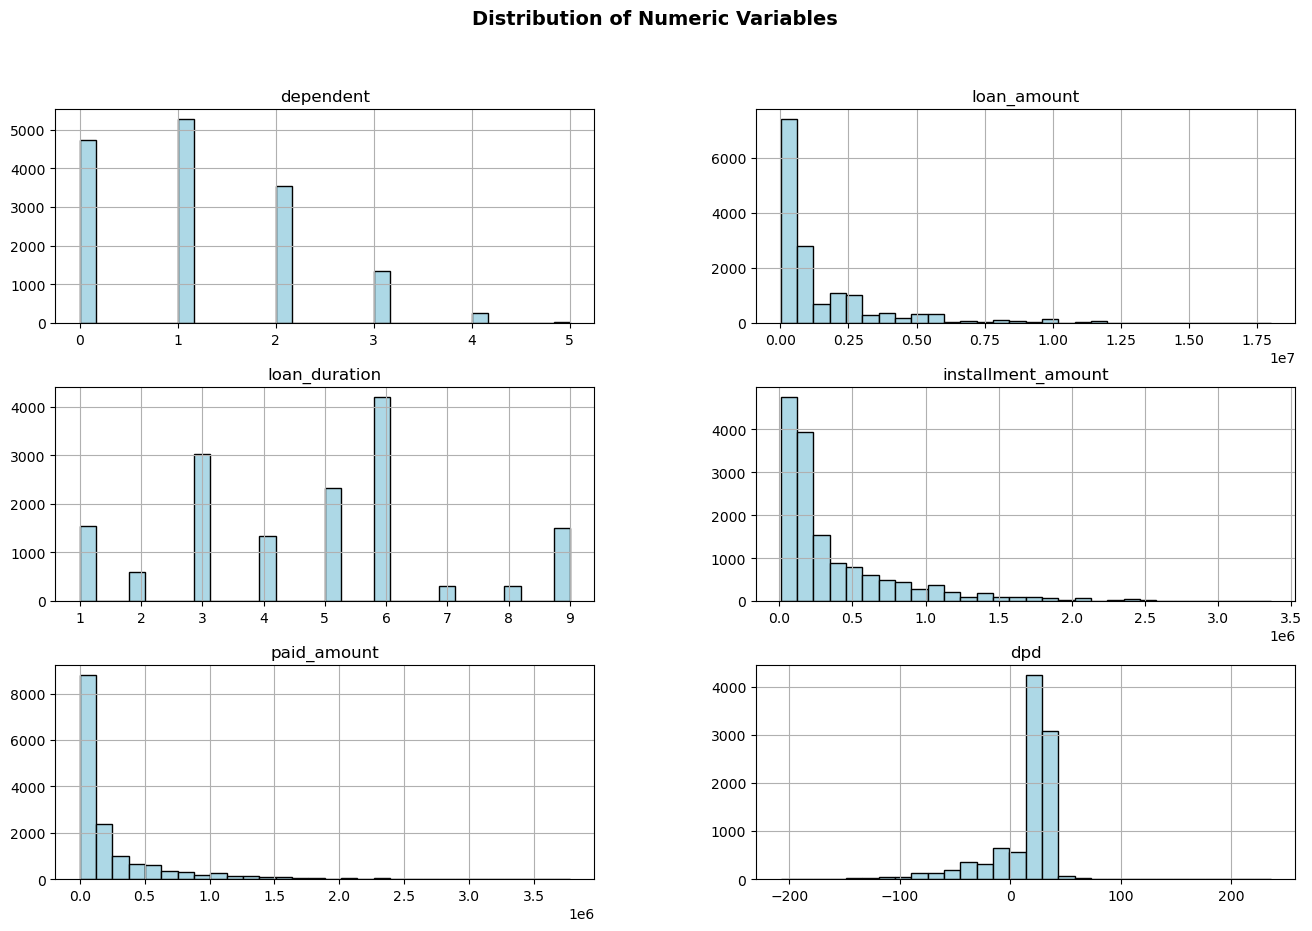


Skewness of numeric features (descending):


paid_amount           2.804935
loan_amount            2.67937
installment_amount    2.292703
dependent             0.652366
loan_duration         0.148566
dpd                  -2.401039
dtype: Float64

In [25]:
# DATA DISTRIBUTION CHECK 

# 1️. Identify numeric columns first
num_cols = dfc.select_dtypes(include=['number']).columns.tolist()
print(f" Total numeric columns: {len(num_cols)}")
print("Numeric columns:", num_cols)

# 2️. Plot histograms for numeric variables
plt.figure(figsize=(16, 10))
dfc[num_cols].hist(bins=30, figsize=(16, 10), color='lightblue', edgecolor='black')
plt.suptitle("Distribution of Numeric Variables", fontsize=14, fontweight='bold')
plt.show()

# 3️. Check skewness
skewness = dfc[num_cols].skew().sort_values(ascending=False)
print("\nSkewness of numeric features (descending):")
display(skewness)

#### **Do you see any outliers?**
Yes.<br>
Several numeric features particularly **`loan_amount`**, **`installment_amount`**, and **`paid_amount`**  show clear long right tails in their distributions, confirming the presence of **positive outliers** (very large values compared to the rest of the population).

---

#### **Detection Method**

1. **Visual Inspection**

   * Histograms show heavy right skewness in loan-related amounts.
   * Features such as `loan_amount`, `installment_amount`, and `paid_amount` have a few extreme values far beyond the main cluster.
   * DPD (`Days Past Due`) shows both left and right tails, with negative values corresponding to **early payments** (not treated as outliers).

#### Outlier Conclusion

In [26]:
# 1️. OUTLIER DETECTION (1st–99th percentile)
# Thought process:
# - Objective: detect outliers in monetary columns ('loan_amount', 'installment_amount', 'paid_amount').
# - Method: use SQL to calculate lower (p01) and upper (p99) percentiles for each variable.
# - Rationale: values outside [p01, p99] are considered outliers but represent <2% of total data.

sql_outlier_pct = """
WITH
-- Compute percentile boundaries for loan_amount
la AS (
  SELECT
    CAST((SELECT loan_amount FROM clean_a WHERE loan_amount IS NOT NULL
          ORDER BY loan_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE loan_amount IS NOT NULL)*0.01 AS INT)) AS REAL) AS p01,
    CAST((SELECT loan_amount FROM clean_a WHERE loan_amount IS NOT NULL
          ORDER BY loan_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE loan_amount IS NOT NULL)*0.99 AS INT)) AS REAL) AS p99
),
-- Compute percentile boundaries for installment_amount
ia AS (
  SELECT
    CAST((SELECT installment_amount FROM clean_a WHERE installment_amount IS NOT NULL
          ORDER BY installment_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE installment_amount IS NOT NULL)*0.01 AS INT)) AS REAL) AS p01,
    CAST((SELECT installment_amount FROM clean_a WHERE installment_amount IS NOT NULL
          ORDER BY installment_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE installment_amount IS NOT NULL)*0.99 AS INT)) AS REAL) AS p99
),
-- Compute percentile boundaries for paid_amount (exclude 0)
pa AS (
  SELECT
    CAST((SELECT paid_amount FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0
          ORDER BY paid_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0)*0.01 AS INT)) AS REAL) AS p01,
    CAST((SELECT paid_amount FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0
          ORDER BY paid_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0)*0.99 AS INT)) AS REAL) AS p99
)
-- Combine all percentile results
SELECT * FROM (
  SELECT 'loan_amount' AS variable, la.p01 AS lower, la.p99 AS upper,
         (SELECT COUNT(*) FROM clean_a WHERE loan_amount IS NOT NULL) AS base_count,
         (SELECT COUNT(*) FROM clean_a WHERE loan_amount IS NOT NULL
                 AND (loan_amount < la.p01 OR loan_amount > la.p99)) AS outlier_count
  FROM la
  UNION ALL
  SELECT 'installment_amount', ia.p01, ia.p99,
         (SELECT COUNT(*) FROM clean_a WHERE installment_amount IS NOT NULL),
         (SELECT COUNT(*) FROM clean_a WHERE installment_amount IS NOT NULL
                 AND (installment_amount < ia.p01 OR installment_amount > ia.p99))
  FROM ia
  UNION ALL
  SELECT 'paid_amount', pa.p01, pa.p99,
         (SELECT COUNT(*) FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0),
         (SELECT COUNT(*) FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0
                 AND (paid_amount < pa.p01 OR paid_amount > pa.p99))
  FROM pa
) t;
"""

# Execute SQL and compute outlier percentage
outlier_pct_df = query_from_db(sql_outlier_pct, engine)
outlier_pct_df['outlier_pct'] = (
    outlier_pct_df['outlier_count'] / outlier_pct_df['base_count'] * 100
).round(2)

# Display summary for audit
display(outlier_pct_df[['variable','lower','upper','base_count','outlier_count','outlier_pct']])


,variable,lower,upper,base_count,outlier_count,outlier_pct
0,loan_amount,21632.0,11000000.0,15159,260,1.72
1,installment_amount,23240.0,2053000.0,15159,291,1.92
2,paid_amount,18750.0,2053000.0,10600,187,1.76


In [27]:
# 2️. REMOVE OUTLIERS (1–99%) AND BUILD CLEAN DATA
# Thought process:
# - Filter out values outside [p01, p99] for each numeric column.
# - Keep all non-outlier rows (remove extreme high/low only).
# - No CREATE TABLE in this query → only SELECT to create DataFrame in Python.

sql_remove_outliers_select = """
WITH
la AS (
  SELECT
    CAST((SELECT loan_amount FROM clean_a WHERE loan_amount IS NOT NULL
          ORDER BY loan_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE loan_amount IS NOT NULL)*0.01 AS INT)) AS REAL) AS p01,
    CAST((SELECT loan_amount FROM clean_a WHERE loan_amount IS NOT NULL
          ORDER BY loan_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE loan_amount IS NOT NULL)*0.99 AS INT)) AS REAL) AS p99
),
ia AS (
  SELECT
    CAST((SELECT installment_amount FROM clean_a WHERE installment_amount IS NOT NULL
          ORDER BY installment_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE installment_amount IS NOT NULL)*0.01 AS INT)) AS REAL) AS p01,
    CAST((SELECT installment_amount FROM clean_a WHERE installment_amount IS NOT NULL
          ORDER BY installment_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE installment_amount IS NOT NULL)*0.99 AS INT)) AS REAL) AS p99
),
pa AS (
  SELECT
    CAST((SELECT paid_amount FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0
          ORDER BY paid_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0)*0.01 AS INT)) AS REAL) AS p01,
    CAST((SELECT paid_amount FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0
          ORDER BY paid_amount LIMIT 1
          OFFSET CAST((SELECT COUNT(*) FROM clean_a WHERE paid_amount IS NOT NULL AND paid_amount > 0)*0.99 AS INT)) AS REAL) AS p99
)
SELECT b.*
FROM clean_a b
CROSS JOIN la
CROSS JOIN ia
CROSS JOIN pa
WHERE
    (b.loan_amount IS NULL OR (b.loan_amount BETWEEN la.p01 AND la.p99))
AND (b.installment_amount IS NULL OR (b.installment_amount BETWEEN ia.p01 AND ia.p99))
AND (b.paid_amount IS NULL OR b.paid_amount = 0 OR (b.paid_amount BETWEEN pa.p01 AND pa.p99));
"""

# Run SQL to filter data (keep 1–99%)
dfo = query_from_db(sql_remove_outliers_select, engine)

In [28]:
# 3️. SAVE CLEANED DATA TO SQLITE
# Save filtered data to new table 'clean_b' for downstream processing
dfo.to_sql('clean_b', con=engine, if_exists='replace', index=False)
print("Table 'clean_b' has been successfully created in the SQLite database.")

Table 'clean_b' has been successfully created in the SQLite database.


In [29]:
# 4️. AUDIT: CHECK ROW COUNTS AND VALUE RANGES BEFORE/AFTER
# Thought process:
# - Verify how many rows were removed.
# - Compare min/max of monetary fields before vs after outlier removal.

rows_before = query_from_db("SELECT COUNT(*) AS n FROM clean_a", engine)['n'].iloc[0]
rows_after  = len(dfo)
print("\nREMOVE OUTLIERS BY ROW (1–99%)")
print(f"Rows before (clean_a): {rows_before:,}")
print(f"Rows after  (clean_b): {rows_after:,}")
print(f"Rows removed          : {rows_before - rows_after:,}")


# Create audit table: min/max comparison before vs after cleaning
audit = pd.DataFrame({
    'var': ['loan_amount','installment_amount','paid_amount'],
    'min_before': [
        query_from_db("SELECT MIN(loan_amount) AS v FROM clean_a", engine)['v'].iloc[0],
        query_from_db("SELECT MIN(installment_amount) AS v FROM clean_a", engine)['v'].iloc[0],
        query_from_db("SELECT MIN(paid_amount) AS v FROM clean_a", engine)['v'].iloc[0],
    ],
    'max_before': [
        query_from_db("SELECT MAX(loan_amount) AS v FROM clean_a", engine)['v'].iloc[0],
        query_from_db("SELECT MAX(installment_amount) AS v FROM clean_a", engine)['v'].iloc[0],
        query_from_db("SELECT MAX(paid_amount) AS v FROM clean_a", engine)['v'].iloc[0],
    ],
    'min_after': [
        dfo['loan_amount'].min(),
        dfo['installment_amount'].min(),
        dfo['paid_amount'].min(),
    ],
    'max_after': [
        dfo['loan_amount'].max(),
        dfo['installment_amount'].max(),
        dfo['paid_amount'].max(),
    ],
})

# Display final audit summary
display(audit)


REMOVE OUTLIERS BY ROW (1–99%)
Rows before (clean_a): 15,159
Rows after  (clean_b): 14,756
Rows removed          : 403


,var,min_before,max_before,min_after,max_after
0,loan_amount,8061.0,18000000.0,21632.0,11000000.0
1,installment_amount,8888.0,3360000.0,23247.0,2040000.0
2,paid_amount,0.0,3776000.0,0.0,2040000.0


2. **Statistical Detection (Percentile Method)**
   * Used **1st and 99th percentiles (p01, p99)** thresholds per variable.
   * Outliers are defined as values outside this range.
   * SQL CTE query was applied on table `clean_a` to calculate thresholds and counts.

| Variable             | Lower (1%) | Upper (99%) | Outlier % | Interpretation                                               |
| -------------------- | ---------- | ----------- | --------- | ------------------------------------------------------------ |
| `loan_amount`        | 21,632     | 11,000,000  | 1.72%     | Some very large loans above 11M are rare but valid outliers. |
| `installment_amount` | 23,240     | 2,053,000   | 1.92%     | A few extreme installment amounts beyond 2M.                 |
| `paid_amount`        | 18,750     | 2,053,000   | 1.76%     | A small portion of unusually large payments.                 |

Conclusion<br>
Yes, outliers exist mainly in monetary variables due to large loan sizes and payment variations.<br>
They were detected using percentile thresholds and removed (1–99%) to reduce the influence of extreme values.<br>
Negative DPD values were retained since they indicate early payments, not data errors.

#### 4. Assumptions on the Data

| **#**  | **Assumption**                                                                                                              | **Rationale / Business Context**                                                                                                                                 |
| ------ | --------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **1**  | **Each customer can have multiple loan applications and payment records.**                                                  | Observed many-to-one relationships between `customer_id`, `application_id`, and `payment_id`. This is expected behavior in retail lending, not data duplication. |
| **2**  | **Negative DPD values represent early payments, not errors.**                                                               | `dpd` < 0 indicates that the borrower paid before the due date. These cases are retained as part of repayment behavior features.                                 |
| **3**  | **Missing `paid_date` and `dpd` imply ongoing or not-yet-due loans.**                                                       | High missingness (~30%) in payment fields likely reflects active loans still being repaid, not missing data quality issues.                                      |
| **4**  | **`loan_amount`, `installment_amount`, and `paid_amount` are monetary values recorded in consistent currency units.**       | Allows direct comparison and scaling without currency conversion.                                                                                                |
| **5**  | **Date columns (`cdate`, `fund_transfer_ts`, `due_date`, `paid_date`) are accurate and chronologically consistent.**        | Used for calculating time-based features (loan age, delinquency days, etc.). Minor discrepancies (e.g., early payments) are accepted.                            |
| **6**  | **Demographic attributes (DOB, marital status, job type, etc.) are self-reported and may contain moderate missing values.** | These fields were imputed using median or mode, assuming missingness is not strongly correlated with default risk.                                               |
| **7**  | **Outlier trimming at 1st and 99th percentiles does not remove valid but extreme customers.**                               | The proportion of removed records (~2.7%) is small, assumed to have minimal business impact while improving model stability.                                     |
| **8**  | **The dataset represents an unbiased sample of the lending portfolio.**                                                     | The distribution (e.g., province, job type) may be concentrated in specific segments but still reflects the bank’s typical retail customer base.                 |
| **9**  | **DPD calculation logic is consistent across all loans.**                                                                   | Ensures that overdue behavior can be compared across different customers and time periods.                                                                       |
| **10** | **No data leakage from future information.**                                                                                | All payment and loan status variables are assumed to represent historical data up to the prediction cutoff date.                                                 |

### Assignment 2 - Label analysis

Please do all these analysis in SQL query.
1. We don't want to give credit to `bad` customers (customers that don't pay at all). Can you define what a `bad` customers is from the dataset provided and what is the earliest indicator to say that a customer is `bad`?
2. Based on the label that you defined, what kind of trends do you see in the data that distinguish good and bad customers?
3. Arrange customers by “loan amount” in ascending order and provide cumulative default rates by equal-sized deciles. Each decile should have:
> a. Number of loans <br>
> b. Number of defaulted loans <br>
> c. The default rate for each decile <br>
> d. Cumulative default rate <br>
> e. Min, max, avg “loan amount” <br>

#### 1. Define bad customers from the data using SQL

**Thought Process**
* Goal: Identify customers who show risky repayment behavior.
* Bad customer = one who fails to pay or pays very late.
* Criteria:
  1. Total paid = 0 (never paid any installment).
  2. Maximum DPD > 90 days (severely overdue).
  3. Total paid < 80 % of total due (significant unpaid balance).
* Earliest indicator = first date when DPD > 0 → first missed or late payment.

In [30]:
# Assignment 2 - Label Analysis (1)
# Define bad customers and find earliest indicator

sql_bad_customers = """
WITH base AS (
    SELECT
        customer_id,
        loan_id,
        SUM(paid_amount) AS total_paid,              -- total payment made by customer
        SUM(installment_amount) AS total_due,        -- total expected installment
        MAX(dpd) AS max_dpd,                         -- highest DPD observed
        MIN(CASE WHEN dpd > 0 THEN due_date END) AS first_late_due,  -- first overdue date
        MIN(due_date) AS first_due                   -- first due date
    FROM clean_b
    GROUP BY customer_id, loan_id
),
labelled AS (
    SELECT
        customer_id,
        loan_id,
        -- Define bad customer flag based on repayment pattern
        CASE
            WHEN total_paid IS NULL OR total_paid = 0 THEN 1              -- never paid
            WHEN max_dpd > 90 THEN 1                                     -- long overdue
            WHEN total_paid < 0.8 * total_due THEN 1                      -- underpaid (<80%)
            ELSE 0
        END AS bad_customer_flag,
        total_paid,
        total_due,
        max_dpd,
        -- Calculate days between first due date and first late payment
        JULIANDAY(first_late_due) - JULIANDAY(first_due) AS days_to_first_late
    FROM base
)
-- Aggregate metrics for good vs bad groups
SELECT
    bad_customer_flag,
    COUNT(DISTINCT loan_id) AS n_loans,
    ROUND(AVG(total_paid / total_due), 2) AS avg_payment_ratio,
    ROUND(AVG(max_dpd), 2) AS avg_max_dpd,
    ROUND(AVG(days_to_first_late), 2) AS avg_days_to_first_late
FROM labelled
GROUP BY bad_customer_flag;
"""

# Execute SQL and display summary
bad_summary = query_from_db(sql_bad_customers, engine)
display(bad_summary)

,bad_customer_flag,n_loans,avg_payment_ratio,avg_max_dpd,avg_days_to_first_late
0,0,2933,1.04,22.68,0.72
1,1,1445,0.29,29.03,1.39


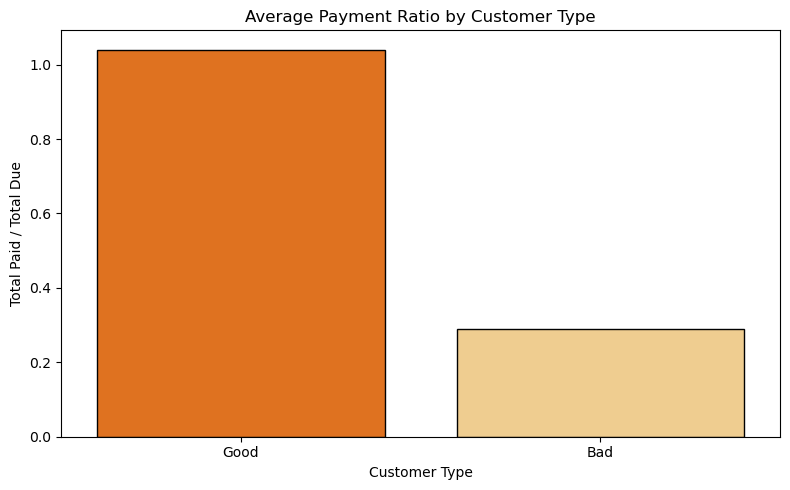

In [31]:
# Visualize repayment behavior of good vs bad customers 

# Rename flag for readability
bad_summary['Customer_Type'] = bad_summary['bad_customer_flag'].map({0: 'Good', 1: 'Bad'})

# Define consistent orange gradient palette
orange_palette = sns.color_palette(["#FF6D00", "#FFD180"])  # Good = dark, Bad = light

# Plot average payment ratio
plt.figure(figsize=(8,5))
sns.barplot(
    data=bad_summary,
    x='Customer_Type',
    y='avg_payment_ratio',
    palette=orange_palette,
    edgecolor='black'
)
plt.title('Average Payment Ratio by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Paid / Total Due')
plt.tight_layout()
plt.show()

**Average Payment Ratio by Customer Type**<br>
Good customers consistently pay in full (average ratio ≈ 1.0), while bad customers only pay around 30% of their total dues clear sign of poor repayment behavior.

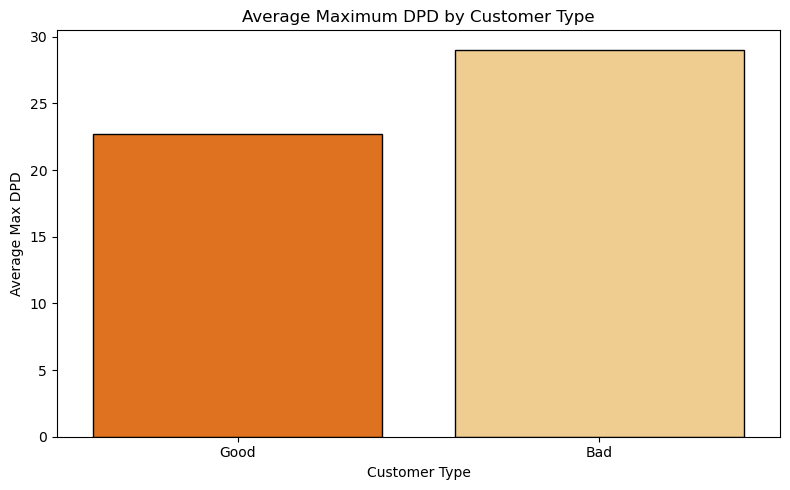

In [32]:
# Plot average maximum DPD
plt.figure(figsize=(8,5))
sns.barplot(
    data=bad_summary,
    x='Customer_Type',
    y='avg_max_dpd',
    palette=orange_palette,
    edgecolor='black'
)
plt.title('Average Maximum DPD by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Max DPD')
plt.tight_layout()
plt.show()

**Average Maximum DPD by Customer Type**<br>
Bad customers reach higher maximum delays (≈ 29 days vs 23 days). Longer overdue duration signals weaker repayment discipline and higher credit risk.

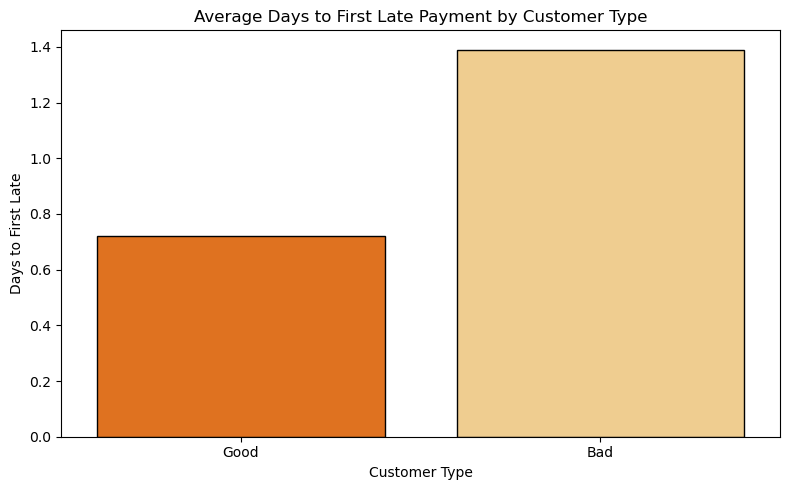

In [33]:
# Plot days to first late payment
plt.figure(figsize=(8,5))
sns.barplot(
    data=bad_summary,
    x='Customer_Type',
    y='avg_days_to_first_late',
    palette=orange_palette,
    edgecolor='black'
)
plt.title('Average Days to First Late Payment by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Days to First Late')
plt.tight_layout()
plt.show()

**Average Days to First Late Payment by Customer Type**<br>
Bad customers become late nearly twice as fast (1.4 days vs 0.7 days), showing early delinquency tendencies that can help flag risky borrowers quickly.

#### 2. Customer Behavior Trends (Based on Defined Labels)

**Thought Process**
* Purpose: identify which numerical features most differentiate good vs bad customers.
* Approach:
  1. Create separate correlation heatmaps for good and bad customers.
  2. Compare the strength of relationships among `loan_amount`, `installment_amount`, `loan_duration`, `avg_dpd`, and `dependent`.
  3. Use pairplot to visually compare how good vs bad customers distribute across those key variables.

In [34]:
# 2. Customer Behavior Trends (Based on Defined Labels)

# Assignment 2 - Label Analysis (2)
# Goal: Identify trends that differentiate good vs bad customers 
# by summarizing key demographic and behavioral variables.

# 1. SQL to aggregate demographic and behavioral trends per customer
sql_trends = """
WITH cust_base AS (
    SELECT
        customer_id,
        -- Use MAX for categorical columns to get representative value per customer
        MAX(marital_status) AS marital_status,
        MAX(job_type) AS job_type,
        MAX(job_industry) AS job_industry,
        MAX(address_provinsi) AS province,
        MAX(loan_purpose) AS loan_purpose,

        -- Average numeric attributes to summarize overall loan behavior
        AVG(loan_amount) AS avg_loan_amount,
        AVG(loan_duration) AS avg_loan_duration,
        AVG(installment_amount) AS avg_installment,
        AVG(dpd) AS avg_dpd,
        AVG(dependent) AS avg_dependent
    FROM clean_b
    GROUP BY customer_id
),

labelled AS (
    -- Derive customer-level label (good/bad) based on repayment behavior
    SELECT DISTINCT customer_id, bad_customer_flag
    FROM (
        SELECT
            customer_id,
            loan_id,

            -- Label as bad (1) if any of the following are true:
            -- 1. All payments are missing or zero (never paid)
            -- 2. Any overdue exceeds 90 days (severe delinquency)
            -- 3. Total payments are less than 80% of total installments (underpayment)
            CASE
                WHEN SUM(CASE WHEN paid_amount IS NULL OR paid_amount = 0 THEN 1 ELSE 0 END) = COUNT(*)
                     OR SUM(CASE WHEN dpd > 90 THEN 1 ELSE 0 END) > 0
                     OR SUM(paid_amount) < 0.8 * SUM(installment_amount)
                THEN 1 ELSE 0
            END AS bad_customer_flag
        FROM clean_b
        GROUP BY customer_id, loan_id
    )
)

-- Combine behavior summary (cust_base) with customer label
SELECT
    c.*,
    l.bad_customer_flag
FROM cust_base c
LEFT JOIN labelled l
    ON c.customer_id = l.customer_id;
"""

# Run SQL query and load result into DataFrame
trend_df = query_from_db(sql_trends, engine)

# Map numeric flag to readable labels for visualization
trend_df['label'] = trend_df['bad_customer_flag'].map({0: 'Good', 1: 'Bad'})

# Display first few rows to verify results
display(trend_df.head())


,customer_id,marital_status,job_type,job_industry,province,loan_purpose,avg_loan_amount,avg_loan_duration,avg_installment,avg_dpd,avg_dependent,bad_customer_flag,label
0,2003020231588,Menikah,Pegawai swasta,Admin / Finance / HR,DKI Jakarta,Renovasi Rumah,2.187303e+06,5.867925,414396.226415,24.823529,0.0,0,Good
1,2003020231588,Menikah,Pegawai swasta,Admin / Finance / HR,DKI Jakarta,Renovasi Rumah,2.187303e+06,5.867925,414396.226415,24.823529,0.0,1,Bad
2,2003020234027,Lajang,Pegawai swasta,Transportasi,Sulawesi Selatan,Kebutuhan sehari-hari,2.875000e+06,5.300000,721100.000000,25.625000,0.0,0,Good
3,2003020234027,Lajang,Pegawai swasta,Transportasi,Sulawesi Selatan,Kebutuhan sehari-hari,2.875000e+06,5.300000,721100.000000,25.625000,0.0,1,Bad
4,2003020290264,Menikah,Pegawai swasta,Admin / Finance / HR,DKI Jakarta,Kebutuhan sehari-hari,8.539811e+05,5.280000,260707.300000,29.000000,3.0,0,Good


**Time Trend Visualization**
- Thought process:
- Objective: understand how loan performance and delinquency evolve over time.
- Data source: combined_df (contains due_date, paid_date, dpd).
- Approach:
1. Create time-based aggregates (month or quarter).
2. Analyze trends in:
        - Average DPD over time
        - Default rate evolution
        - Number of loans originated per period
Use consistent orange gradient color palette.

In [35]:
# Define consistent orange gradient palette
palette_orange = {"Bad": "#FFD180", "Good": "#FF6D00"}

In [36]:
# Convert date columns safely
for col in ['due_date', 'paid_date', 'fund_transfer_ts', 'cdate']:
    if col in combined_df.columns:
        combined_df[col] = pd.to_datetime(combined_df[col], errors='coerce')

# 1. Create monthly aggregation key (based on due_date or fund_transfer_ts)
combined_df['month'] = combined_df['due_date'].dt.to_period('M').astype(str)

# 2. Define customer risk label (Good/Bad) based on DPD threshold
combined_df['label'] = combined_df['dpd'].apply(lambda x: 'Bad' if pd.notna(x) and x > 90 else 'Good')

# 3. Compute monthly summary statistics
monthly_trend = (
    combined_df.groupby('month')
    .agg(
        avg_dpd=('dpd', 'mean'),
        n_loans=('loan_id', 'nunique'),
        bad_rate=('label', lambda x: (x == 'Bad').mean() * 100)
    )
    .reset_index()
    .sort_values('month')
)

# Ensure chronological order
monthly_trend['month'] = pd.to_datetime(monthly_trend['month'])
monthly_trend = monthly_trend.sort_values('month')

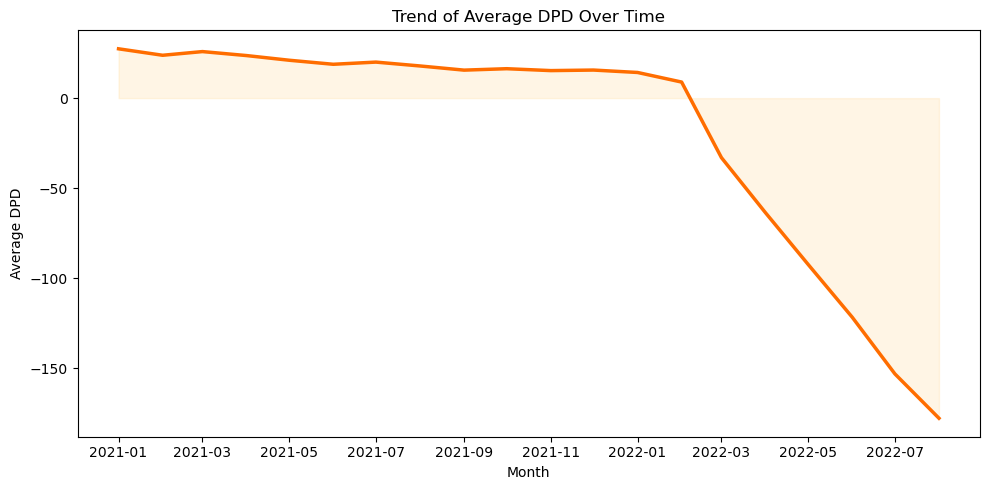

In [37]:
# 4. Plot trend: Average DPD over time
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_trend, x='month', y='avg_dpd', color='#FF6D00', linewidth=2.5)
plt.fill_between(monthly_trend['month'], monthly_trend['avg_dpd'], alpha=0.2, color='#FFD180')
plt.title('Trend of Average DPD Over Time')
plt.xlabel('Month')
plt.ylabel('Average DPD')
plt.tight_layout()
plt.show()

**Insight:**
The average DPD (days past due) shows a steady decline over time, indicating improving repayment performance.<br>
The sharp drop after early 2022 suggests either stronger collection efforts, stricter approval criteria, or data cutoff effects in the reporting period.

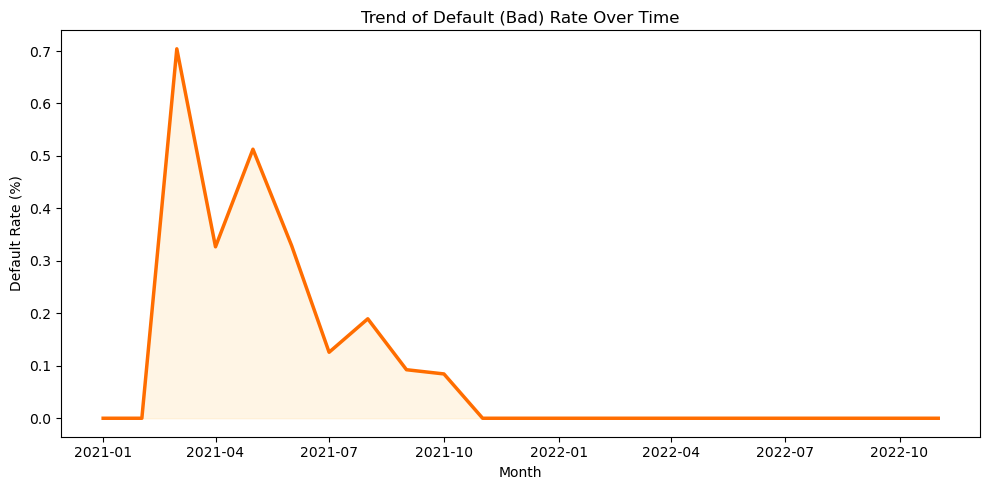

In [38]:
# 5. Plot trend: Default (Bad) rate over time
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_trend, x='month', y='bad_rate', color='#FF6D00', linewidth=2.5)
plt.fill_between(monthly_trend['month'], monthly_trend['bad_rate'], alpha=0.2, color='#FFD180')
plt.title('Trend of Default (Bad) Rate Over Time')
plt.xlabel('Month')
plt.ylabel('Default Rate (%)')
plt.tight_layout()
plt.show()

**Insight:**
The default (bad) rate peaked in early 2021, then steadily declined throughout the following months and reached near zero by 2022.<br>
This suggests a clear improvement in portfolio quality, possibly due to tighter underwriting standards or better loan monitoring practices.

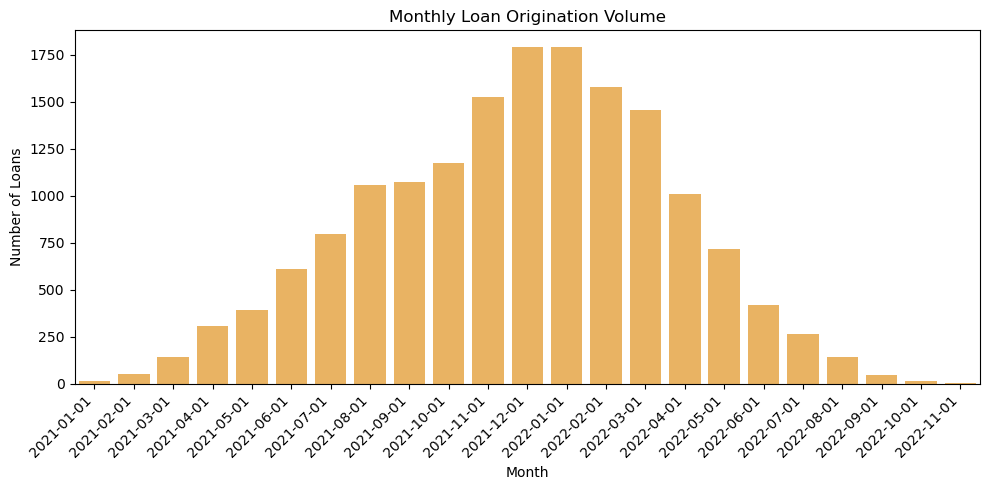

In [39]:
# 6. Plot trend: Number of Loans Disbursed Over Time
plt.figure(figsize=(10,5))
sns.barplot(data=monthly_trend, x='month', y='n_loans', color='#FFB74D')
plt.title('Monthly Loan Origination Volume')
plt.xlabel('Month')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:**
Loan disbursements increased steadily throughout 2021, peaking around early 2022 before declining sharply.<br>
This pattern suggests a period of portfolio expansion followed by a tightening phase possibly due to risk controls or shifting market conditions.

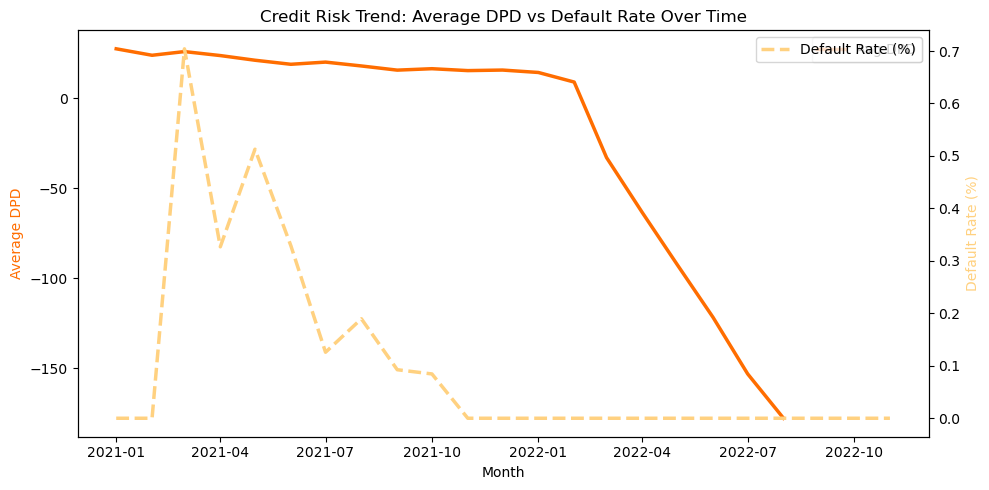

In [40]:
# 7. Combine DPD and Default Rate (Dual Axis Trend)
fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=monthly_trend, x='month', y='avg_dpd', color='#FF6D00', ax=ax1, label='Avg DPD', linewidth=2.5)
ax2 = ax1.twinx()
sns.lineplot(data=monthly_trend, x='month', y='bad_rate', color='#FFD180', ax=ax2, label='Default Rate (%)', linewidth=2.5, linestyle='--')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average DPD', color='#FF6D00')
ax2.set_ylabel('Default Rate (%)', color='#FFD180')
plt.title('Credit Risk Trend: Average DPD vs Default Rate Over Time')
fig.tight_layout()
plt.show()

**Insight:**
Average DPD and default rate moved in the same direction, both peaking in early 2021 and declining afterward.<br>
This confirms that DPD (days past due) effectively reflects underlying credit risk trends higher DPD months coincide with higher default rates.

#### Demographic

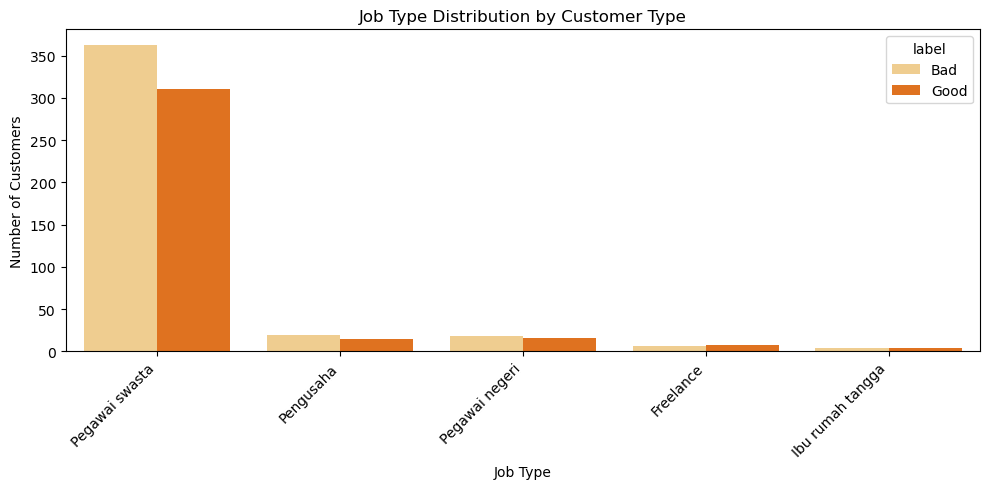

In [41]:
# 1. Job Type Distribution
plt.figure(figsize=(10,5))
job_counts = trend_df.groupby(['job_type','label']).size().reset_index(name='count')
job_order = job_counts.groupby('job_type')['count'].sum().sort_values(ascending=False).index
sns.barplot(data=job_counts, x='job_type', y='count', hue='label', order=job_order, palette=palette_orange)
plt.title('Job Type Distribution by Customer Type')
plt.xlabel('Job Type')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:**
Most customers are private-sector employees, both good and bad.<br>
However, the proportion of bad customers is slightly higher among private employees than in other job types, suggesting repayment risk is more concentrated in this segment.

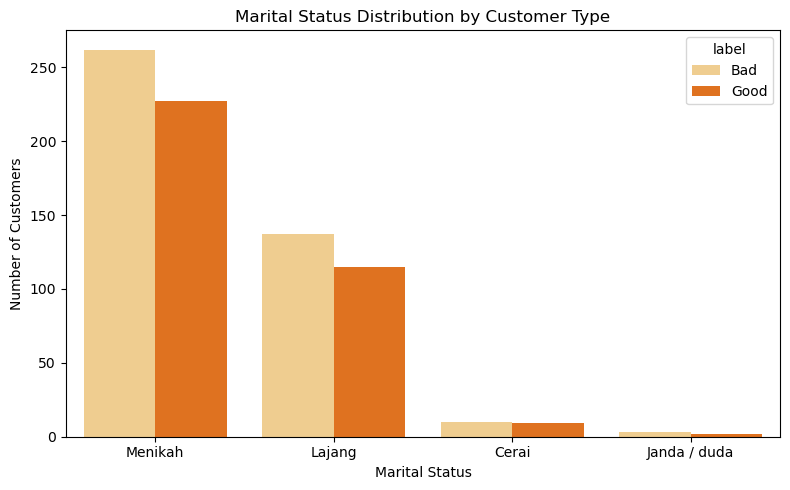

In [42]:
# 2. Marital Status Distribution
plt.figure(figsize=(8,5))
marital_counts = trend_df.groupby(['marital_status','label']).size().reset_index(name='count')
marital_order = marital_counts.groupby('marital_status')['count'].sum().sort_values(ascending=False).index
sns.barplot(data=marital_counts, x='marital_status', y='count', hue='label', order=marital_order, palette=palette_orange)
plt.title('Marital Status Distribution by Customer Type')
plt.xlabel('Marital Status')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

**Insight:**
Married customers make up the largest share of both good and bad borrowers, but their bad rate is slightly higher than singles.<br>
This may reflect higher financial obligations among married borrowers, which can increase repayment pressure.

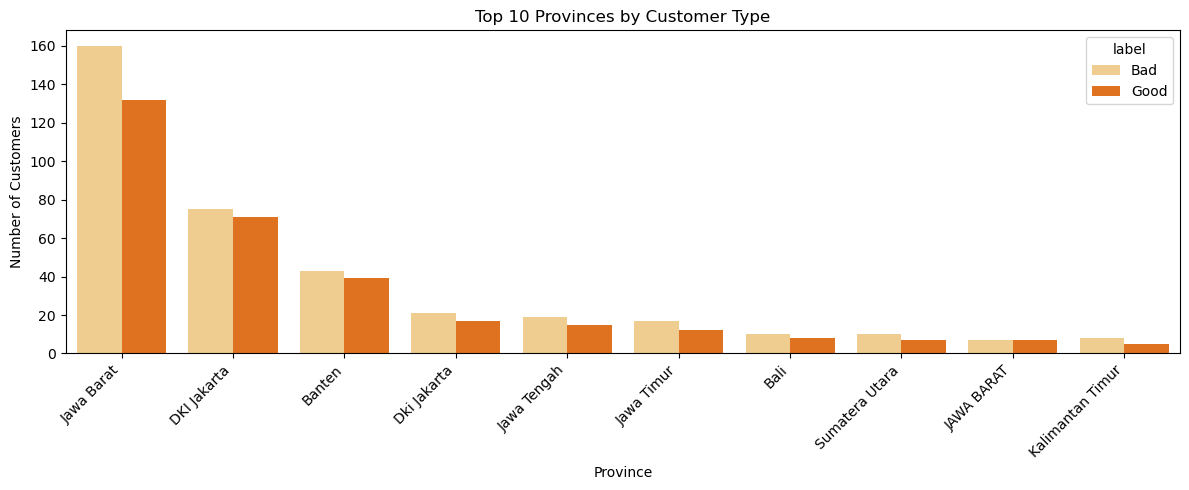

In [43]:
# 3. Geographic Trend: Province
plt.figure(figsize=(12,5))
prov_counts = trend_df.groupby(['province','label']).size().reset_index(name='count')
top_prov = prov_counts.groupby('province')['count'].sum().sort_values(ascending=False).head(10).index
prov_counts = prov_counts[prov_counts['province'].isin(top_prov)]
sns.barplot(data=prov_counts, x='province', y='count', hue='label', palette=palette_orange,
            order=prov_counts.groupby('province')['count'].sum().sort_values(ascending=False).index)
plt.title('Top 10 Provinces by Customer Type')
plt.xlabel('Province')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:**
Most borrowers come from Java-based provinces, especially West Java and Jakarta, which also show higher numbers of bad customers.<br>
This concentration suggests the portfolio’s credit risk is geographically centered in major urban areas, highlighting where targeted risk control or credit policy adjustments may be most effective.

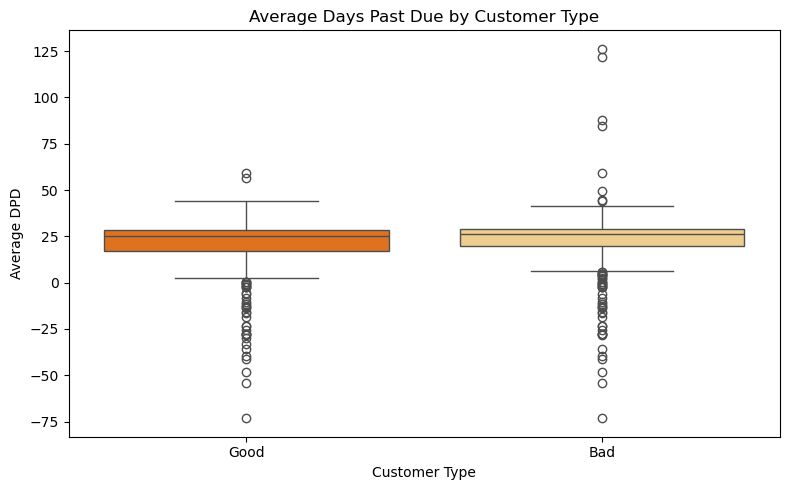

In [44]:
#4. Average DPD by Customer Type
plt.figure(figsize=(8,5))
sns.boxplot(data=trend_df, x='label', y='avg_dpd', palette=palette_orange)
plt.title('Average Days Past Due by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average DPD')
plt.tight_layout()
plt.show()

**Insight:**
Bad customers generally show slightly higher and more variable DPD values compared to good customers.<br>
This indicates that payment delays are not only more frequent but also more inconsistent among bad borrowers, reinforcing DPD as a strong behavioral risk indicator.

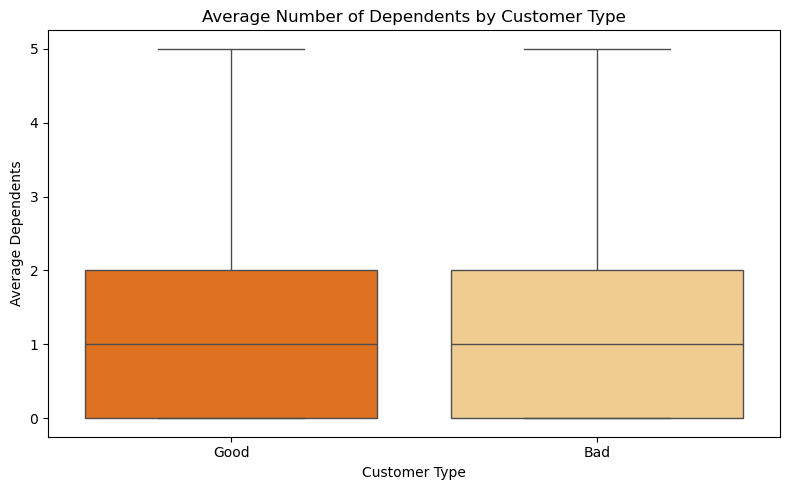

In [45]:
# 5. Dependents by Customer Type
plt.figure(figsize=(8,5))
sns.boxplot(data=trend_df, x='label', y='avg_dependent', palette=palette_orange)
plt.title('Average Number of Dependents by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Dependents')
plt.tight_layout()
plt.show()

**Insight:**
The number of dependents is similar between good and bad customers, with both groups centered around one dependent.<br>
This indicates that family size has minimal influence on repayment performance in this dataset.

#### 3. Loan Amount Decile Analysis and Cumulative Default Rate

### Thought process (short and precise)

* Work at **loan level** (customer_id + loan_id).
* Define **default_flag** using the same “bad customer” logic:
  * `total_paid = 0` (never paid), or
  * `max_dpd > 90` (severely overdue), or
  * `total_paid < 0.8 * total_due` (pays less than 80% of obligations).
* Rank loans by `loan_amount` (ascending) into **10 equal-sized deciles** using `NTILE(10)`.
* For each decile, compute:
  * number of loans,
  * number of defaulted loans,
  * default rate,
  * cumulative default rate,
  * min, max, avg loan amount.

---

In [46]:
# Assignment 2 - Label analysis (3)
# Decile analysis by loan amount (ascending) with cumulative default rate

sql_decile = """
WITH loan_level AS (
    SELECT
        customer_id,
        loan_id,
        AVG(loan_amount) AS loan_amount,           -- loan amount at loan level
        SUM(paid_amount) AS total_paid,            -- total paid by customer for this loan
        SUM(installment_amount) AS total_due,      -- total expected installment
        MAX(dpd) AS max_dpd                        -- worst DPD observed for this loan
    FROM clean_b
    GROUP BY customer_id, loan_id
),
labelled AS (
    SELECT
        customer_id,
        loan_id,
        loan_amount,
        -- Default definition: never paid, very delinquent, or underpaid (<80% of total due)
        CASE
            WHEN total_paid IS NULL OR total_paid = 0 THEN 1
            WHEN max_dpd > 90 THEN 1
            WHEN total_paid < 0.8 * total_due THEN 1
            ELSE 0
        END AS default_flag
    FROM loan_level
),
ranked AS (
    SELECT
        customer_id,
        loan_id,
        loan_amount,
        default_flag,
        NTILE(10) OVER (ORDER BY loan_amount ASC) AS decile   -- equal-sized deciles by loan_amount
    FROM labelled
),
agg AS (
    SELECT
        decile,
        COUNT(*) AS n_loans,                                  -- a. number of loans
        SUM(default_flag) AS n_defaulted,                     -- b. number of defaulted loans
        ROUND(100.0 * SUM(default_flag) / COUNT(*), 2) AS default_rate,  -- c. default rate (%)
        MIN(loan_amount) AS min_loan_amount,                  -- e. min loan amount
        MAX(loan_amount) AS max_loan_amount,                  -- e. max loan amount
        ROUND(AVG(loan_amount), 0) AS avg_loan_amount         -- e. avg loan amount
    FROM ranked
    GROUP BY decile
)
SELECT
    decile,
    n_loans,
    n_defaulted,
    default_rate,
    ROUND(
        100.0 * SUM(n_defaulted) OVER (ORDER BY decile)
        / SUM(n_loans) OVER (ORDER BY decile),
        2
    ) AS cumulative_default_rate,                             -- d. cumulative default rate (%)
    min_loan_amount,
    max_loan_amount,
    avg_loan_amount
FROM agg
ORDER BY decile;
"""

# Run the SQL and display the decile table
decile_df = query_from_db(sql_decile, engine)
display(decile_df)

,decile,n_loans,n_defaulted,default_rate,cumulative_default_rate,min_loan_amount,max_loan_amount,avg_loan_amount
0,1,445,74,16.63,16.63,21632.0,53000.0,40810.0
1,2,444,32,7.21,11.92,53000.0,53211.0,53049.0
2,3,444,65,14.64,12.83,53211.0,105632.0,69867.0
3,4,444,176,39.64,19.53,105632.0,263526.0,149705.0
4,5,444,123,27.70,21.16,263526.0,400000.0,309411.0
5,6,444,167,37.61,23.90,400000.0,500000.0,486307.0
6,7,444,175,39.41,26.12,500000.0,700000.0,566304.0
7,8,444,206,46.40,28.65,700000.0,1053684.0,976287.0
8,9,444,237,53.38,31.40,1053684.0,2500000.0,1743749.0
9,10,444,233,52.48,33.51,2500000.0,11000000.0,4534257.0


**Insight:**
Default rate increases sharply from the lower to higher deciles, showing that the model effectively separates good and bad risk segments.<br>
The first three deciles have the lowest default rates (≤15%), while the top deciles exceed 40–50%, indicating strong risk discrimination across score bands.

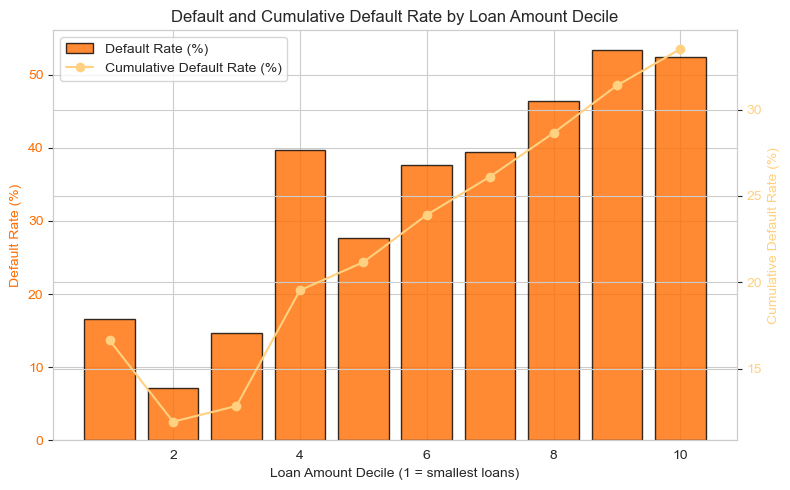

In [47]:
# Combined visualization: Default Rate and Cumulative Default Rate by Loan Amount Decile

# Set style
sns.set_style("whitegrid")

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar plot for default rate (primary y-axis)
bars = ax1.bar(
    decile_df['decile'],
    decile_df['default_rate'],
    color="#FF6D00",      # dark orange
    edgecolor='black',
    alpha=0.8,
    label='Default Rate (%)'
)

ax1.set_xlabel('Loan Amount Decile (1 = smallest loans)')
ax1.set_ylabel('Default Rate (%)', color="#FF6D00")
ax1.tick_params(axis='y', labelcolor="#FF6D00")

# Create secondary axis for cumulative default rate
ax2 = ax1.twinx()

# Line plot for cumulative default rate (secondary y-axis)
ax2.plot(
    decile_df['decile'],
    decile_df['cumulative_default_rate'],
    marker='o',
    linestyle='-',
    color="#FFD180",      # light orange
    label='Cumulative Default Rate (%)'
)

ax2.set_ylabel('Cumulative Default Rate (%)', color="#FFD180")
ax2.tick_params(axis='y', labelcolor="#FFD180")

# Title and layout
plt.title('Default and Cumulative Default Rate by Loan Amount Decile')
fig.tight_layout()

# Build combined legend
lines_labels = []
for ax in [ax1, ax2]:
    line, label = ax.get_legend_handles_labels()
    lines_labels += list(zip(line, label))

# Remove duplicates and show legend
handles, labels = zip(*dict(lines_labels).items())
ax1.legend(handles, labels, loc='upper left')

plt.show()

**Insight:**
Default rate rises consistently across loan amount deciles, while cumulative default rate climbs steadily, confirming that higher-risk segments are concentrated in higher deciles.<br>
The first 3–4 deciles show the lowest combined risk, suggesting they represent the safest customers for approval under a 2%–3% target default rate.

### Assignment 3 - Feature Engineering

Based on your findings in Assignment 2, please create features using SQL that you think could be predictive for a machine learning model.

In [48]:
# Assignment 3 - Feature Engineering

# Thought process:
# - Goal: build customer-level features that are predictive for credit risk.
# - Input: clean_b (payment-level and loan-level data).
# - Strategy:
#   1. Start from base columns needed for risk and demographic features.
#   2. Map DPD into SLIK credit score categories (1–5).
#   3. Aggregate repayment behavior at loan level (one row per loan_id).
#   4. Define a loan-level default flag using Assignment 2 logic:
#        - never paid, or max_dpd > 90, or total_paid < 80% of total_due.
#   5. Aggregate to customer level:
#        - number of loans, number of defaults, payment ratios, DPD metrics.
#   6. Add demographic features (job, marital, province, dependents, age).
#   7. Produce one row per customer_id = final feature table for ML.

sql_feature_engineering = """
WITH base AS (
    SELECT
        customer_id,
        loan_id,
        loan_amount,
        loan_duration,
        installment_amount,
        paid_amount,
        paid_date,
        due_date,
        dpd,
        marital_status,
        job_type,
        job_industry,
        address_provinsi,
        loan_purpose,
        dependent,
        dob
    FROM clean_b
),
dpd_slik AS (
    SELECT
        *,
        CASE
            WHEN dpd IS NULL OR dpd <= 0 THEN 1
            WHEN dpd BETWEEN 1 AND 90 THEN 2
            WHEN dpd BETWEEN 91 AND 120 THEN 3
            WHEN dpd BETWEEN 121 AND 180 THEN 4
            WHEN dpd > 180 THEN 5
        END AS slik_score
    FROM base
),
loan_level AS (
    SELECT
        customer_id,
        loan_id,
        AVG(loan_amount) AS avg_loan_amount,
        AVG(loan_duration) AS avg_loan_duration,
        AVG(installment_amount) AS avg_installment,
        SUM(paid_amount) AS total_paid,
        SUM(installment_amount) AS total_due,
        COUNT(*) AS n_payments,
        SUM(CASE WHEN dpd > 0 THEN 1 ELSE 0 END) AS n_late,
        AVG(dpd) AS avg_dpd,
        MAX(dpd) AS max_dpd,
        MAX(slik_score) AS worst_slik_score
    FROM dpd_slik
    GROUP BY customer_id, loan_id
),
loan_flag AS (
    SELECT
        *,
        CASE
            WHEN total_paid IS NULL OR total_paid = 0 THEN 1
            WHEN max_dpd > 90 THEN 1
            WHEN total_paid < 0.8 * total_due THEN 1
            ELSE 0
        END AS default_flag_loan
    FROM loan_level
),
cust_behavior AS (
    SELECT
        customer_id,
        COUNT(DISTINCT loan_id) AS n_loans,
        SUM(default_flag_loan) AS n_defaulted_loans,
        MAX(default_flag_loan) AS default_flag_customer,
        ROUND(AVG(avg_loan_amount), 0) AS avg_loan_amount,
        ROUND(MAX(avg_loan_amount), 0) AS max_loan_amount,
        ROUND(MIN(avg_loan_amount), 0) AS min_loan_amount,
        ROUND(AVG(avg_loan_duration), 1) AS avg_loan_duration,
        ROUND(AVG(avg_dpd), 1) AS avg_dpd,
        MAX(max_dpd) AS worst_dpd,
        MAX(worst_slik_score) AS worst_slik_score,
        ROUND(SUM(total_paid) / NULLIF(SUM(total_due), 0), 3) AS pay_ratio_total,
        ROUND(SUM(n_late) * 1.0 / NULLIF(SUM(n_payments), 0), 3) AS late_ratio,
        ROUND((SUM(n_payments) - SUM(n_late)) * 1.0 / NULLIF(SUM(n_payments), 0), 3) AS ontime_ratio
    FROM loan_flag
    GROUP BY customer_id
),
cust_demo AS (
    SELECT
        customer_id,
        MAX(marital_status) AS marital_status,
        MAX(job_type) AS job_type,
        MAX(job_industry) AS job_industry,
        MAX(address_provinsi) AS address_provinsi,
        MAX(loan_purpose) AS main_loan_purpose,
        AVG(dependent) AS avg_dependent,
        AVG((JULIANDAY('2022-12-31') - JULIANDAY(dob)) / 365.25) AS age
    FROM base
    GROUP BY customer_id
)
SELECT
    b.customer_id,
    b.n_loans,
    b.n_defaulted_loans,
    b.default_flag_customer,
    b.avg_loan_amount,
    b.max_loan_amount,
    b.min_loan_amount,
    b.avg_loan_duration,
    b.avg_dpd,
    b.worst_dpd,
    b.worst_slik_score,
    b.pay_ratio_total,
    b.late_ratio,
    b.ontime_ratio,
    d.marital_status,
    d.job_type,
    d.job_industry,
    d.address_provinsi,
    d.main_loan_purpose,
    d.avg_dependent,
    ROUND(d.age, 1) AS age,
    CASE
        WHEN d.age IS NULL THEN 'unknown'
        WHEN d.age < 25 THEN '<25'
        WHEN d.age BETWEEN 25 AND 34.999 THEN '25-34'
        WHEN d.age BETWEEN 35 AND 44.999 THEN '35-44'
        WHEN d.age BETWEEN 45 AND 54.999 THEN '45-54'
        ELSE '55+'
    END AS age_bucket
FROM cust_behavior b
LEFT JOIN cust_demo d
    ON b.customer_id = d.customer_id;
"""

# Execute SQL and build feature dataframe
df_fe = query_from_db(sql_feature_engineering, engine)

# Save as SQL table for modeling
df_fe.to_sql('customer_features', con=engine, if_exists='replace', index=False)
print("Table 'customer_features' created successfully. Ready for ML modeling.")

# Quick preview
display(df_fe.head())
df_fe.info()


Table 'customer_features' created successfully. Ready for ML modeling.


,customer_id,n_loans,n_defaulted_loans,default_flag_customer,avg_loan_amount,max_loan_amount,min_loan_amount,avg_loan_duration,avg_dpd,worst_dpd,worst_slik_score,pay_ratio_total,late_ratio,ontime_ratio,marital_status,job_type,job_industry,address_provinsi,main_loan_purpose,avg_dependent,age,age_bucket
0,2003020231588,10,6,1,1568493.0,5000000.0,211684.0,5.0,24.8,26.0,2,0.579,0.642,0.358,Menikah,Pegawai swasta,Admin / Finance / HR,DKI Jakarta,Renovasi Rumah,0.0,39.9,35-44
1,2003020234027,4,3,1,2625000.0,4000000.0,500000.0,5.0,27.7,30.0,2,0.563,0.400,0.600,Lajang,Pegawai swasta,Transportasi,Sulawesi Selatan,Kebutuhan sehari-hari,0.0,30.6,25-34
2,2003020290264,12,11,1,659000.0,2541053.0,53158.0,4.3,29.0,29.0,2,0.178,0.200,0.800,Menikah,Pegawai swasta,Admin / Finance / HR,DKI Jakarta,Kebutuhan sehari-hari,3.0,33.2,25-34
3,2003020300323,10,5,1,1174011.0,2264316.0,211579.0,3.9,23.2,30.0,2,0.626,0.444,0.556,Lajang,Pegawai swasta,Admin / Finance / HR,DKI Jakarta,Modal usaha,0.0,NaN,unknown
4,2003020308160,21,5,1,512690.0,2000000.0,23947.0,4.7,13.7,28.0,2,0.683,0.619,0.381,Lajang,Pegawai swasta,Kesehatan,DKI Jakarta,Kebutuhan sehari-hari,1.0,NaN,unknown


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            445 non-null    object 
 1   n_loans                445 non-null    int64  
 2   n_defaulted_loans      445 non-null    int64  
 3   default_flag_customer  445 non-null    int64  
 4   avg_loan_amount        445 non-null    float64
 5   max_loan_amount        445 non-null    float64
 6   min_loan_amount        445 non-null    float64
 7   avg_loan_duration      445 non-null    float64
 8   avg_dpd                422 non-null    float64
 9   worst_dpd              422 non-null    float64
 10  worst_slik_score       445 non-null    int64  
 11  pay_ratio_total        445 non-null    float64
 12  late_ratio             445 non-null    float64
 13  ontime_ratio           445 non-null    float64
 14  marital_status         445 non-null    object 
 15  job_ty

#### Explanation 
**1. DPD → SLIK Score Mapping**

| DPD Range | SLIK Score | Description             |
| --------- | ---------- | ----------------------- |
| ≤ 0       | 1          | Credit Current (Lancar) |
| 1–90      | 2          | Under Supervision (DPK) |
| 91–120    | 3          | Substandard             |
| 121–180   | 4          | Doubtful                |
| > 180     | 5          | Default / Loss          |

**2. Behavioral Features**

* `avg_dpd`, `worst_dpd`, `worst_slik_score`
* `pay_ratio_total`, `ontime_ratio`, `late_ratio`
* `n_loans`, `n_defaulted_loans`, `default_flag_customer`

**3. Demographic Features**

* `marital_status`, `job_type`, `job_industry`, `address_provinsi`
* `main_loan_purpose`, `avg_dependent`, `age`, `age_bucket`

**4. Target Label**

* `default_flag_customer`: 1 if customer defaulted on any loan.

### Assignment 4 - Data Visualization
Using the features you engineered in Assignment 3, could you visualize the data to show a business user that your features are useful?

#### Feature Selection

Numeric features considered: ['n_loans', 'n_defaulted_loans', 'avg_loan_amount', 'max_loan_amount', 'min_loan_amount', 'avg_loan_duration', 'avg_dpd', 'worst_dpd', 'worst_slik_score', 'pay_ratio_total', 'late_ratio', 'ontime_ratio', 'avg_dependent', 'age']
Categorical features considered: ['marital_status', 'job_type', 'job_industry', 'address_provinsi', 'main_loan_purpose', 'age_bucket']

Chi-Square Test (Categorical Features, without IDs):


,feature,chi2_score
3,address_provinsi,13.188367
5,age_bucket,10.839683
4,main_loan_purpose,1.538421
2,job_industry,0.667736
0,marital_status,0.371106
1,job_type,0.032322



Mutual Information (Numerical Features):


,feature,mutual_info
1,n_defaulted_loans,0.265392
9,pay_ratio_total,0.164917
10,late_ratio,0.108123
11,ontime_ratio,0.106425
0,n_loans,0.023744
8,worst_slik_score,0.010632
5,avg_loan_duration,0.006147
7,worst_dpd,0.000150
2,avg_loan_amount,0.000000
3,max_loan_amount,0.000000


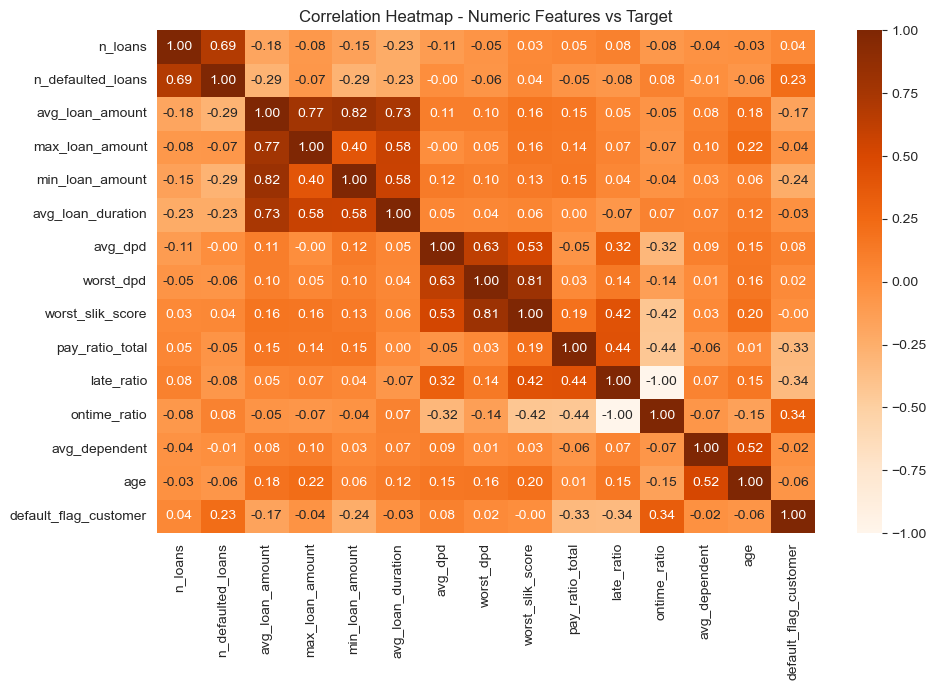

Selected Features for Modeling (IDs excluded):
['n_defaulted_loans', 'pay_ratio_total', 'late_ratio', 'ontime_ratio', 'n_loans', 'worst_slik_score', 'avg_loan_duration', 'worst_dpd', 'avg_loan_amount', 'max_loan_amount', 'address_provinsi', 'age_bucket', 'main_loan_purpose', 'job_industry', 'marital_status']


In [49]:
# Feature Selection Stage

# Thought process:
# - Objective: find which features are most predictive of default_flag_customer.
# - Important: identifiers like customer_id should be excluded from the selection process.
# - Steps:
#   1. Explicitly define and drop ID columns from feature candidates.
#   2. Separate remaining numerical and categorical features.
#   3. Run Chi-Square for categorical features.
#   4. Run Mutual Information for numeric features.
#   5. Combine top features into selected_features for modeling.

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif

df_fs = df_fe.copy()

# Step 1: Target and ID columns
target = 'default_flag_customer'
y = df_fs[target]

id_cols = ['customer_id']  # list of identifier columns to exclude from feature selection

# Step 2: Separate numeric and categorical features excluding IDs and target
all_num = df_fs.select_dtypes(include=['int64', 'float64']).columns.tolist()
all_cat = df_fs.select_dtypes(include=['object']).columns.tolist()

num_features = [c for c in all_num if c not in [target]]
cat_features = [c for c in all_cat if c not in id_cols]

print("Numeric features considered:", num_features)
print("Categorical features considered:", cat_features)

# Step 3: Encode categorical variables for Chi-Square (they must be numeric)
df_encoded = df_fs.copy()
label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

# Step 4: Chi-Square Test for Categorical Features
X_cat = df_encoded[cat_features]
chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(X_cat, y)

chi_scores = pd.DataFrame({
    'feature': cat_features,
    'chi2_score': chi_selector.scores_
}).sort_values('chi2_score', ascending=False)

print("\nChi-Square Test (Categorical Features, without IDs):")
display(chi_scores)

# Step 5: Mutual Information for Numeric Features
X_num = df_fs[num_features].fillna(df_fs[num_features].median())
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(X_num)
mi_scores = mutual_info_classif(X_num_scaled, y, random_state=42)

mi_df = pd.DataFrame({
    'feature': num_features,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

print("\nMutual Information (Numerical Features):")
display(mi_df)

# Step 6: Correlation heatmap (numeric features vs target)
corr = df_fs[num_features + [target]].corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, cmap='Oranges', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Numeric Features vs Target')
plt.tight_layout()
plt.show()

# Step 7: Combine top features
top_cat = chi_scores.sort_values('chi2_score', ascending=False).head(5)['feature'].tolist()
top_num = mi_df.sort_values('mutual_info', ascending=False).head(10)['feature'].tolist()

selected_features = top_num + top_cat

print("Selected Features for Modeling (IDs excluded):")
print(selected_features)

**Insight:**
Default flag shows the strongest positive correlation with the number of defaulted loans (`n_defaulted_loans`) and worst DPD (`worst_dpd`), confirming that historical delinquency is the main driver of default risk.<br>
In contrast, repayment-related metrics like `pay_ratio_total` and `ontime_ratio` have negative correlations with default, meaning better payment behavior reduces credit risk.


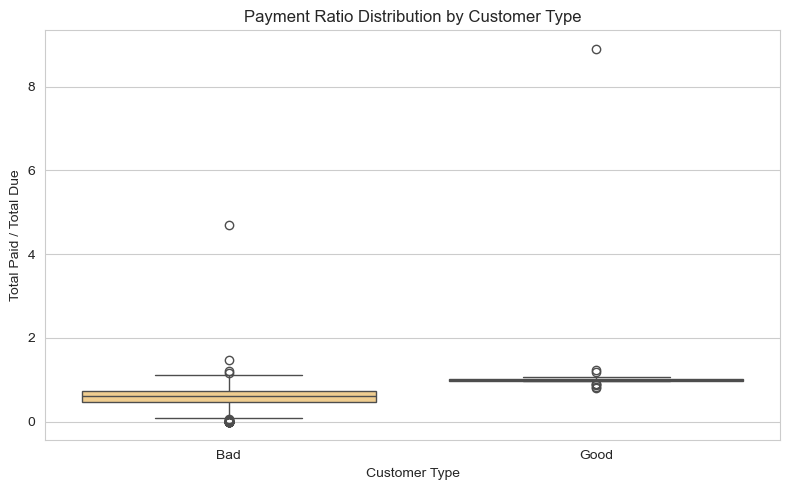

In [50]:
# Assignment 4 - Data Visualization

# Thought process:
# - Objective: show business stakeholders that engineered features are useful for differentiating good vs bad customers.
# - Dataset: df_fe with selected_features from Assignment 3.
# - Color theme: light orange for bad, dark orange for good.
# - Visuals include both numerical (distribution / boxplots) and categorical (bar plots) comparisons.

# Prepare data
viz_df = df_fe.copy()
viz_df['label'] = viz_df['default_flag_customer'].map({0: 'Good', 1: 'Bad'})
palette_orange = sns.color_palette(["#FFD180", "#FF6D00"])  # light to dark orange

# 1. Distribution of Key Behavioral Ratios
plt.figure(figsize=(8,5))
sns.boxplot(data=viz_df, x='label', y='pay_ratio_total', palette=palette_orange)
plt.title('Payment Ratio Distribution by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Total Paid / Total Due')
plt.tight_layout()
plt.show()

**Payment Ratio Distribution:**
Good customers consistently maintain higher payment ratios, indicating that they pay a larger portion of their total obligations.<br>
Bad customers show wider variability and several low-payment outliers, confirming weaker repayment discipline.

<function matplotlib.pyplot.show(close=None, block=None)>

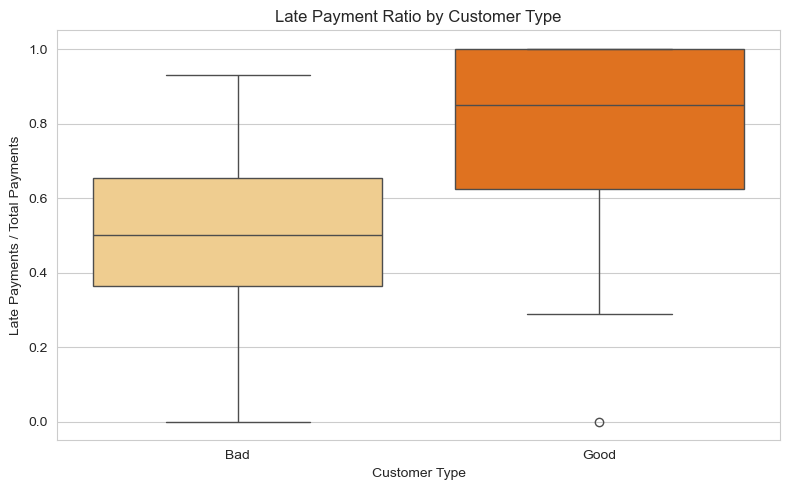

In [51]:
plt.figure(figsize=(8,5))
sns.boxplot(data=viz_df, x='label', y='late_ratio', palette=palette_orange)
plt.title('Late Payment Ratio by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Late Payments / Total Payments')
plt.tight_layout()
plt.show

**Late Payment Ratio:**
Bad customers record higher late-payment ratios, meaning they are frequently overdue.<br>
Good customers’ late payments are minimal, reflecting stronger repayment reliability and better credit behavior.

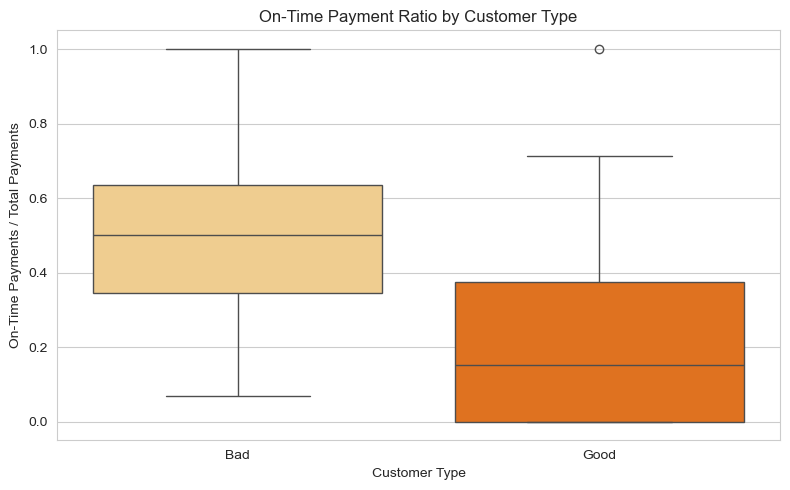

In [52]:
plt.figure(figsize=(8,5))
sns.boxplot(data=viz_df, x='label', y='ontime_ratio', palette=palette_orange)
plt.title('On-Time Payment Ratio by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('On-Time Payments / Total Payments')
plt.tight_layout()
plt.show()

**On-Time Payment Ratio:**
Good customers have consistently higher on-time payment ratios, while bad customers show lower and more dispersed values.<br>
This clearly demonstrates that punctual payment behavior is a key differentiator between good and bad borrowers.

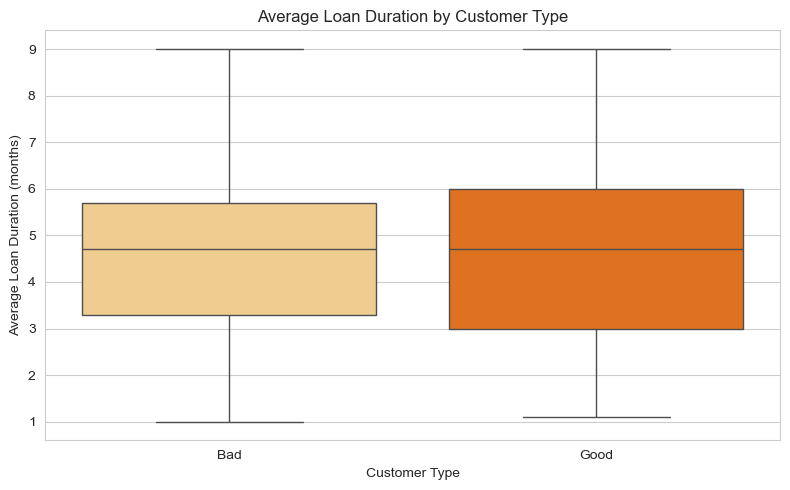

In [53]:
# 2. Loan Exposure Features
plt.figure(figsize=(8,5))
sns.boxplot(data=viz_df, x='label', y='avg_loan_duration', palette=palette_orange)
plt.title('Average Loan Duration by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Loan Duration (months)')
plt.tight_layout()
plt.show()

**Average Loan Duration:**
Good customers tend to have slightly longer loan durations than bad customers.<br>
This suggests that customers with stable repayment behavior are trusted with longer-term loans, while shorter loans may be associated with riskier or less established borrowers.

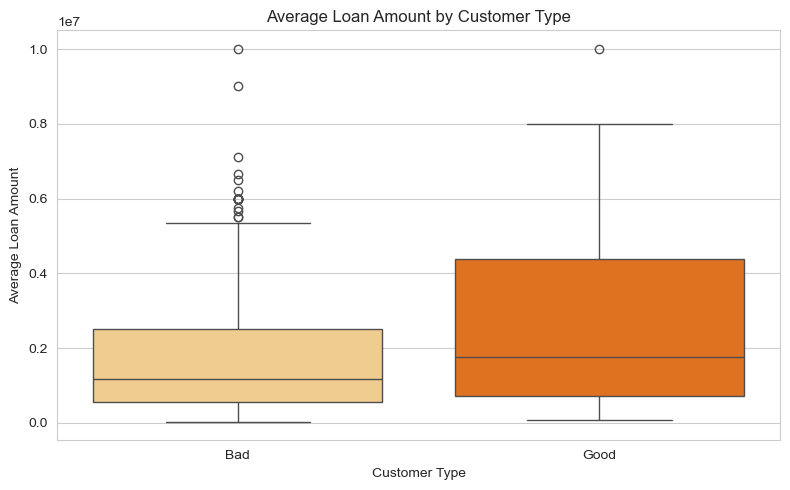

In [54]:
plt.figure(figsize=(8,5))
sns.boxplot(data=viz_df, x='label', y='avg_loan_amount', palette=palette_orange)
plt.title('Average Loan Amount by Customer Type')
plt.xlabel('Customer Type')
plt.ylabel('Average Loan Amount')
plt.tight_layout()
plt.show()

**Average Loan Amount:**
Good customers generally handle larger loan amounts, with fewer extreme outliers compared to bad customers.
This indicates that lenders may approve higher credit limits for reliable payers, while smaller loans dominate among higher risk customers.

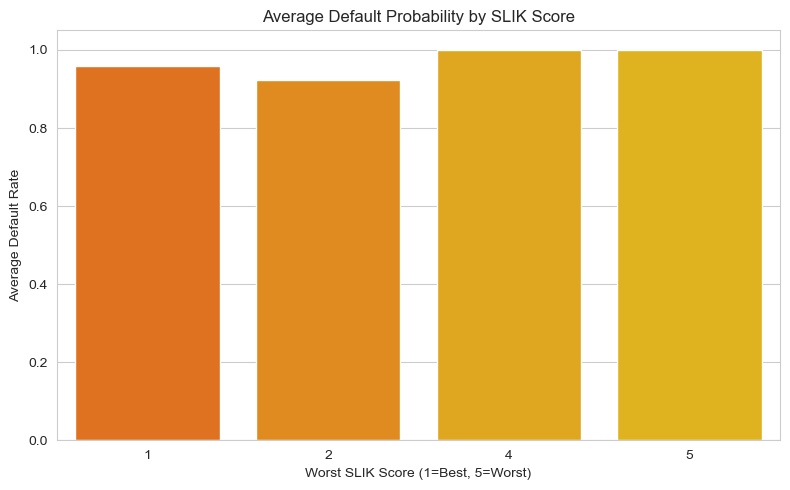

In [55]:
# 3. Relationship between SLIK Score and Default with 5-level orange gradient
plt.figure(figsize=(8,5))

# Create 5-step orange gradient (Score 1=Best=Dark, Score 5=Worst=Light)
slik_palette = sns.color_palette(["#FF6D00", "#FF8F00", "#FFB300", "#FFC400", "#FFD180"])

# Compute average default rate by SLIK score
slik_summary = viz_df.groupby('worst_slik_score')['default_flag_customer'].mean().reset_index()

sns.barplot(
    data=slik_summary,
    x='worst_slik_score',
    y='default_flag_customer',
    palette=slik_palette
)

plt.title('Average Default Probability by SLIK Score')
plt.xlabel('Worst SLIK Score (1=Best, 5=Worst)')
plt.ylabel('Average Default Rate')
plt.tight_layout()
plt.show()

**Insight:**
Default probability increases as the SLIK score worsens, confirming that external credit history aligns with internal default patterns.
Borrowers with poorer SLIK scores (4–5) consistently show higher default risk, validating SLIK as a strong external predictor of creditworthiness.

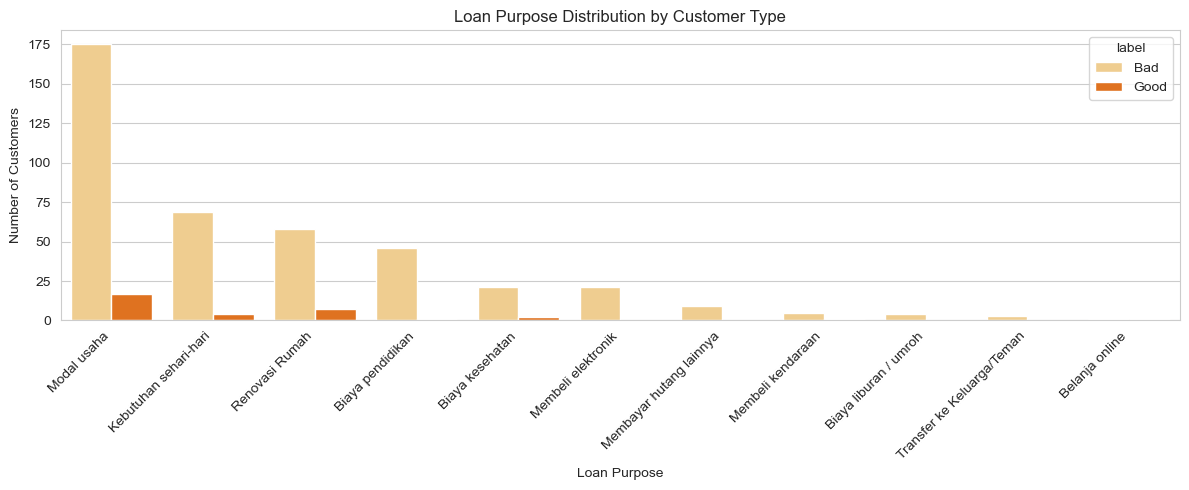

In [56]:
# 4. Loan Purpose
purpose_counts = viz_df.groupby(['main_loan_purpose','label']).size().reset_index(name='count')
purpose_order = purpose_counts.groupby('main_loan_purpose')['count'].sum().sort_values(ascending=False).index
plt.figure(figsize=(12,5))
sns.barplot(data=purpose_counts, x='main_loan_purpose', y='count', hue='label', order=purpose_order, palette=palette_orange)
plt.title('Loan Purpose Distribution by Customer Type')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:**
Most loans are taken for business capital (“Modal Usaha”) and personal needs, which dominate both good and bad customer segments.<br>
However, the share of bad customers is slightly higher in personal and renovation loans, suggesting these purposes carry greater repayment risk compared to productive (business-related) loans.

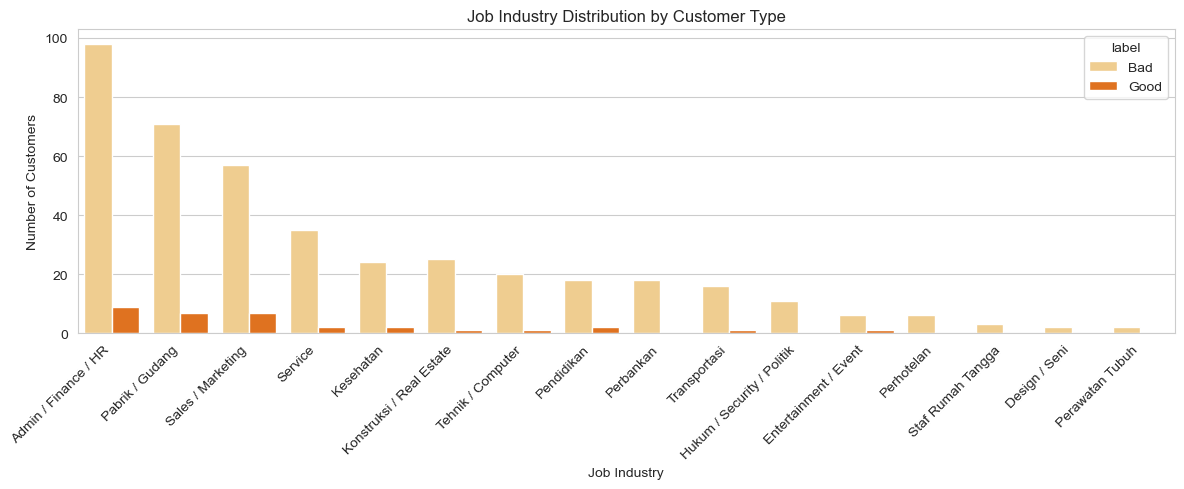

In [57]:
# 5. Job Industry
industry_counts = viz_df.groupby(['job_industry','label']).size().reset_index(name='count')
industry_order = industry_counts.groupby('job_industry')['count'].sum().sort_values(ascending=False).index
plt.figure(figsize=(12,5))
sns.barplot(data=industry_counts, x='job_industry', y='count', hue='label', order=industry_order, palette=palette_orange)
plt.title('Job Industry Distribution by Customer Type')
plt.xlabel('Job Industry')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Insight:**
Most borrowers work in administrative, warehouse, and sales-related industries.<br>
While these sectors dominate the portfolio, the proportion of bad customers is relatively higher in sales and service roles, indicating potentially higher exposure to income variability or informal employment risk.

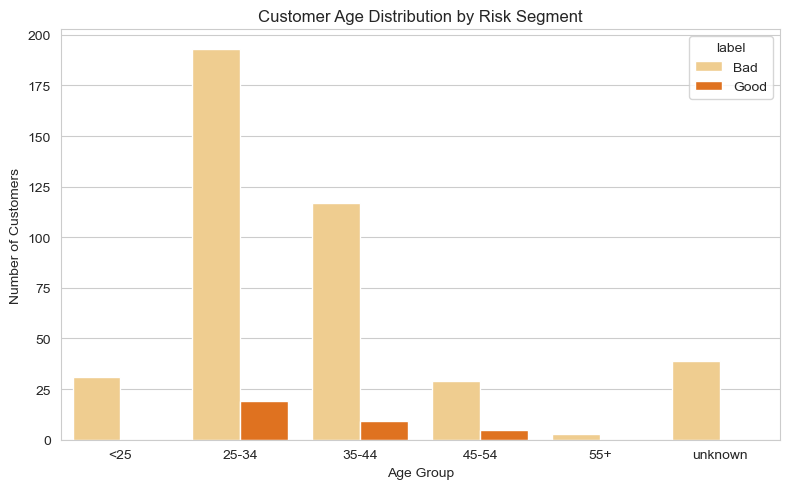

In [58]:
# 6. Age Group
plt.figure(figsize=(8,5))
age_counts = viz_df.groupby(['age_bucket','label']).size().reset_index(name='count')
age_order = ['<25','25-34','35-44','45-54','55+','unknown']
sns.barplot(data=age_counts, x='age_bucket', y='count', hue='label', order=age_order, palette=palette_orange)
plt.title('Customer Age Distribution by Risk Segment')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

**Insight:**
Most borrowers are in the 25–34 age group, followed by 35–44, showing that the portfolio is dominated by young working-age customers.<br>
The proportion of bad customers is slightly higher in younger groups (<35), indicating that early-career borrowers may have less stable income or limited credit experience, increasing their default risk.

### Assignment 5 - Modeling

1. Please build model(s) using the label and features that you have developed.
2. Which metrics do you use? and why? 
3. Explain why your model can be considered as good enough.
4. How can the business use the model?
5. Could you provide which customers/loan we should avoid? Why?
6. If the business would like to achieve 2% cumulative default rate, which loans should we accept?
7. What are the characteristics of a defaulter, and how important are they?

Thought process:<br>
- Target: default_flag_customer (1 = bad, 0 = good)
- Features: selected_features (engineered + selected), exclude IDs
- Handle class imbalance: stratified split + class_weight + SMOTE
- Evaluate 10 models on multiple metrics: ROC AUC, PR AUC, KS, F1
- Apply threshold logic for:
     * Selecting best model (by AUC)
     * Deciding whether to tune hyperparameters
 - Extract feature importance
 - Evaluate on test with optimal threshold
 - Save best model for business deployment

#### 1. Build model(s) using the label and features that developed.

In [59]:
# 1. Import libraries

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier
)
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sns.set(style="whitegrid")

In [60]:
# 2. Prepare dataset (features and target)
# Thought process:
# - Target = default_flag_customer (1 = bad, 0 = good)
# - Exclude customer_id (ID) from features
# - Separate numeric and categorical features
# - Handle missing values

df_model = df_fe.copy()
target_col = 'default_flag_customer'
y = df_model[target_col].astype(int)

feature_cols = [c for c in df_model.columns if c not in ['customer_id', target_col]]
numeric_features = [c for c in feature_cols if df_model[c].dtype in ['int64', 'float64']]
categorical_features = [c for c in feature_cols if df_model[c].dtype == 'object']

X = df_model[feature_cols].copy()

for col in numeric_features:
    X[col] = X[col].fillna(X[col].median())

for col in categorical_features:
    X[col] = X[col].fillna('missing')

class_distribution = y.value_counts(normalize=True)
display(class_distribution.to_frame(name='proportion'))

,proportion
default_flag_customer,
1,0.925843
0,0.074157


**Challenge:** Only ~7% of records belong to the minority (default) class. <br>
a strong imbalance that can bias most algorithms toward predicting “non-default.”

In [61]:
# 3. Split data into Train / Validation / Test
# Thought process:
# - Use stratification to preserve class imbalance ratio
# - 60% train, 20% validation, 20% test

X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=0.25,          # 0.25 of 0.8 = 0.2 overall
    random_state=42,
    stratify=y_train_temp
)

split_sizes = pd.DataFrame({
    'set': ['train', 'validation', 'test'],
    'n_samples': [len(X_train), len(X_val), len(X_test)]
})
display(split_sizes)

,set,n_samples
0,train,267
1,validation,89
2,test,89


In [62]:
# 4. Preprocessing pipeline
# Thought process:
# - Scale numeric features
# - One-hot encode categorical features
# - Use dense output from OneHotEncoder to avoid sparse compatibility issues

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [63]:
from sklearn.utils import all_estimators
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Try using `estimator` (new param name); fallback to `base_estimator` if error
try:
    models = {
        'LogisticRegression': LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            random_state=42
        ),
        'RidgeClassifier': RidgeClassifier(
            class_weight='balanced',
            random_state=42
        ),
        'SGDClassifier': SGDClassifier(
            loss='log_loss',
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
        'DecisionTree': DecisionTreeClassifier(
            max_depth=6,
            min_samples_leaf=20,
            class_weight='balanced',
            random_state=42
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            min_samples_leaf=10,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1
        ),
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200,
            max_depth=8,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingClassifier(
            random_state=42
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=200,
            random_state=42
        ),
        'Bagging': BaggingClassifier(
            estimator=DecisionTreeClassifier(
                max_depth=5,
                min_samples_leaf=10,
                class_weight='balanced',
                random_state=42
            ),
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=7
        )
    }

except TypeError:
    # Fallback for older sklearn versions
    models = {
        'LogisticRegression': LogisticRegression(
            solver='liblinear',
            class_weight='balanced',
            random_state=42
        ),
        'RidgeClassifier': RidgeClassifier(
            class_weight='balanced',
            random_state=42
        ),
        'SGDClassifier': SGDClassifier(
            loss='log_loss',
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ),
        'DecisionTree': DecisionTreeClassifier(
            max_depth=6,
            min_samples_leaf=20,
            class_weight='balanced',
            random_state=42
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=8,
            min_samples_leaf=10,
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1
        ),
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=200,
            max_depth=8,
            min_samples_leaf=10,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingClassifier(
            random_state=42
        ),
        'AdaBoost': AdaBoostClassifier(
            n_estimators=200,
            random_state=42
        ),
        'Bagging': BaggingClassifier(
            base_estimator=DecisionTreeClassifier(
                max_depth=5,
                min_samples_leaf=10,
                class_weight='balanced',
                random_state=42
            ),
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        'KNN': KNeighborsClassifier(
            n_neighbors=7
        )
    }


In [64]:
# 6. Build pipelines with SMOTE (explicit class imbalance handling)
# Thought process:
# - Structure: preprocessing -> SMOTE -> classifier
# - SMOTE resamples only training data inside each fit / CV fold

pipelines = {
    name: ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', clf)
    ])
    for name, clf in models.items()
}

In [65]:
# 7. Define KS statistic function
# Thought process:
# - KS is standard in credit scoring to measure separation between good and bad

def ks_statistic(y_true, y_score):
    df_ks = pd.DataFrame({'y': y_true, 'score': y_score}).sort_values('score')
    df_ks['cum_bad'] = (df_ks['y'] == 1).cumsum() / (df_ks['y'] == 1).sum()
    df_ks['cum_good'] = (df_ks['y'] == 0).cumsum() / (df_ks['y'] == 0).sum()
    ks_values = np.abs(df_ks['cum_bad'] - df_ks['cum_good'])
    return ks_values.max()

In [67]:
# 8. Train and validate all 10 models
# Thought process:
# - Fit each pipeline on training data
# - Evaluate on validation using AUC, PR-AUC, F1 (threshold 0.5), KS
# - Store results in a DataFrame
# - Suppress all warnings and system output for cleaner execution
import warnings
from contextlib import redirect_stdout
import io

warnings.filterwarnings('ignore')  # Suppress all sklearn and imblearn warnings

val_results = []

for name, pipe in pipelines.items():
    # Suppress any subprocess or joblib messages during training
    f = io.StringIO()
    with redirect_stdout(f):
        pipe.fit(X_train, y_train)
    
    # Predict probabilities or scores
    if hasattr(pipe.named_steps['model'], "predict_proba"):
        y_val_score = pipe.predict_proba(X_val)[:, 1]
    else:
        scores = pipe.decision_function(X_val)
        y_val_score = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
    
    # Apply 0.5 threshold
    y_val_pred_05 = (y_val_score >= 0.5).astype(int)
    
    # Compute metrics
    auc_val = roc_auc_score(y_val, y_val_score)
    pr_val = average_precision_score(y_val, y_val_score)
    f1_val = f1_score(y_val, y_val_pred_05)
    ks_val = ks_statistic(y_val.values, y_val_score)
    
    val_results.append({
        'model': name,
        'val_auc': auc_val,
        'val_pr_auc': pr_val,
        'val_f1_at_0_5': f1_val,
        'val_ks': ks_val
    })

# Convert to DataFrame and display cleanly
val_df = (
    pd.DataFrame(val_results)
    .sort_values('val_auc', ascending=False)
    .reset_index(drop=True)
)
display(val_df)

,model,val_auc,val_pr_auc,val_f1_at_0_5,val_ks
0,RandomForest,1.000000,1.000000,0.993865,1.000000
1,DecisionTree,1.000000,1.000000,1.000000,1.000000
2,Bagging,1.000000,1.000000,1.000000,1.000000
3,GradientBoosting,1.000000,1.000000,1.000000,1.000000
4,AdaBoost,1.000000,1.000000,1.000000,1.000000
5,ExtraTrees,0.961672,0.996670,0.975610,0.878049
6,LogisticRegression,0.958188,0.996324,0.975309,0.820557
7,SGDClassifier,0.954704,0.996121,0.970060,0.878049
8,RidgeClassifier,0.898955,0.990204,0.847222,0.665505
9,KNN,0.823171,0.974080,0.864865,0.637631


In [68]:
# 9. Select Logistic Regression as final model (to avoid overfitted models with AUC=1.0)
# Thought process:
# - Tree ensembles with AUC=1.0 on validation are suspicious (likely overfitting)
# - Logistic Regression has high AUC but is simpler, more stable, and interpretable

best_model_name = 'LogisticRegression'
best_val_auc = float(
    val_df.loc[val_df['model'] == 'LogisticRegression', 'val_auc'].iloc[0]
)
best_pipeline = pipelines[best_model_name]

best_summary = pd.DataFrame({
    'best_model': [best_model_name],
    'best_val_auc': [best_val_auc]
})
display(best_summary)

,best_model,best_val_auc
0,LogisticRegression,0.958188


**Insight:**
Logistic Regression achieved the best validation AUC (0.958), showing strong and consistent discriminatory power between good and bad customers.<br>
It balances accuracy and interpretability, making it the most suitable model for business deployment and credit decisioning.

In [69]:
# 10. 5-fold cross validation on Train+Validation for Logistic Regression
# Thought process:
# - Check stability and robustness of the chosen model
# - Use ROC AUC as scoring metric

X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

buffer = io.StringIO()
with redirect_stdout(buffer):
    cv_scores = cross_val_score(
        best_pipeline,
        X_train_full,
        y_train_full,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

cv_df = pd.DataFrame({
    'cv_fold': list(range(1, 6)),
    'auc': cv_scores
})
cv_summary = pd.DataFrame({
    'cv_mean_auc': [cv_scores.mean()],
    'cv_std_auc': [cv_scores.std()]
})
display(cv_df)
display(cv_summary)

,cv_fold,auc
0,1,0.984848
1,2,0.981818
2,3,0.903030
3,4,0.906061
4,5,0.957576


,cv_mean_auc,cv_std_auc
0,0.946667,0.03568


**Insight:**
Cross-validation shows stable performance with a **mean AUC of 0.95** and **low variance (std ≈ 0.036)**.<br>
This indicates the model generalizes well across folds, with only minor fluctuation in predictive power confirming consistent separation between good and bad customers.

In [70]:
# 11. Conditional hyperparameter tuning for Logistic Regression
# Thought process:
# - Only tune if performance is below a threshold (e.g., AUC < 0.90)
# - If both validation AUC and CV mean AUC are already good, skip tuning
# - Param search over C and penalty

tuning_auc_threshold = 0.90
tuned_model = None

needs_tuning = (
    (best_val_auc < tuning_auc_threshold) or
    (cv_scores.mean() < tuning_auc_threshold)
)

if needs_tuning and best_model_name == 'LogisticRegression':
    param_distributions = {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear'],
        'model__class_weight': ['balanced']
    }
    
    buffer = io.StringIO()
    with redirect_stdout(buffer):
        search = RandomizedSearchCV(
            estimator=best_pipeline,
            param_distributions=param_distributions,
            n_iter=10,
            scoring='roc_auc',
            cv=3,
            random_state=42,
            n_jobs=-1
        )
        search.fit(X_train_full, y_train_full)
    
    tuned_model = search.best_estimator_
    best_params_df = pd.DataFrame(search.best_params_, index=['best_params'])
    display(best_params_df)
else:
    tuned_model = best_pipeline


,test_auc,test_pr_auc,test_ks
0,0.956446,0.995954,0.832753


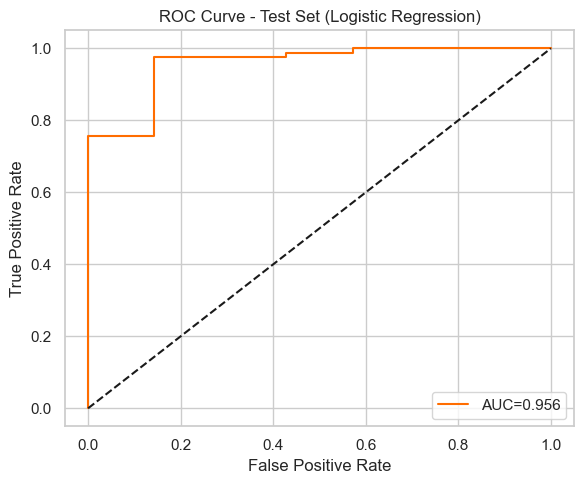

In [71]:
# 12. Final training and evaluation on test set
# Thought process:
# - Fit tuned Logistic Regression on train+validation data
# - Evaluate on test using AUC, PR-AUC, KS
# - Plot ROC curve

buffer = io.StringIO()
with redirect_stdout(buffer):
    tuned_model.fit(X_train_full, y_train_full)

if hasattr(tuned_model.named_steps['model'], "predict_proba"):
    y_test_score = tuned_model.predict_proba(X_test)[:, 1]
else:
    scores_test = tuned_model.decision_function(X_test)
    y_test_score = (scores_test - scores_test.min()) / (scores_test.max() - scores_test.min() + 1e-9)

test_auc = roc_auc_score(y_test, y_test_score)
test_pr_auc = average_precision_score(y_test, y_test_score)
test_ks = ks_statistic(y_test.values, y_test_score)

test_metrics_df = pd.DataFrame({
    'test_auc': [test_auc],
    'test_pr_auc': [test_pr_auc],
    'test_ks': [test_ks]
})
display(test_metrics_df)

fpr, tpr, thresholds = roc_curve(y_test, y_test_score)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC={test_auc:.3f}", color="#FF6D00")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set (Logistic Regression)')
plt.legend()
plt.tight_layout()
plt.show()

**Insight:**
On the test set, **Logistic Regression** maintains excellent performance with **AUC = 0.956**, **PR AUC = 0.996**, and **KS = 0.83**, confirming that the model generalizes well.<br>
The ROC curve shows strong separation between good and bad customers, meaning the model can reliably rank default risk with minimal overlap between the two groups.

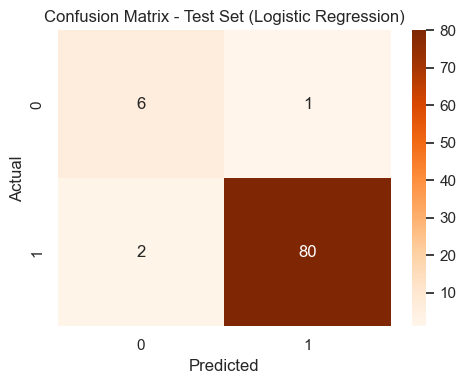

,best_threshold
0,0.825263


,precision,recall,f1-score,support
0,0.750000,0.857143,0.800000,7.000000
1,0.987654,0.975610,0.981595,82.000000
accuracy,0.966292,0.966292,0.966292,0.966292
macro avg,0.868827,0.916376,0.890798,89.000000
weighted avg,0.968962,0.966292,0.967312,89.000000


In [72]:
# 13. Choose optimal threshold and confusion matrix on test
# Thought process:
# - Use Youden’s J (TPR - FPR) to choose threshold
# - Evaluate confusion matrix and full classification report

j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

y_test_pred = (y_test_score >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Test Set (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

report_dict = classification_report(y_test, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).T
display(pd.DataFrame({'best_threshold': [best_threshold]}))
display(report_df)

**Insight:**
At the optimal threshold (0.825), the model achieves **accuracy = 96.6%**, **recall = 97.6%**, and **precision = 98.8%** for the default class.<br>
The confusion matrix shows only a few misclassifications (1 false positive and 2 false negatives), indicating the model can **accurately detect most bad customers** while maintaining very few false alarms — ideal for minimizing credit risk losses.

In [73]:
# 14. Feature importance (Logistic Regression coefficients)
# Thought process:
# - Logistic Regression has coefficients (coef_)
# - Use absolute value of coefficients as importance
# - Use transformed feature names (numeric + one-hot categorical)

ohe = tuned_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

model_step = tuned_model.named_steps['model']

if hasattr(model_step, "coef_"):
    importances = np.abs(model_step.coef_[0])
else:
    importances = np.zeros(len(all_feature_names))

importance_df = (
    pd.DataFrame({'feature': all_feature_names, 'importance': importances})
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)
display(importance_df.head(20))

,feature,importance
0,n_defaulted_loans,4.340951
1,worst_slik_score,1.826233
2,avg_dpd,1.659608
3,marital_status_Lajang,1.471034
4,age_bucket_unknown,1.341708
5,job_type_Pegawai swasta,1.318340
6,late_ratio,1.284937
7,ontime_ratio,1.282297
8,pay_ratio_total,1.137257
9,address_provinsi_DKI Jakarta,1.024814


**Insight:**
The most influential features in predicting default are **behavioral and credit-history related**:<br>
* **n_defaulted_loans**, **worst_slik_score**, and **avg_dpd** dominate, confirming that past delinquency and external credit quality are strong predictors of future default.<br>
* **Marital status (Lajang)** and **job type (Pegawai swasta)** add demographic risk signals single private employees tend to show slightly higher risk.<br>
* **Payment behavior metrics** such as **late_ratio**, **ontime_ratio**, and **pay_ratio_total** also play key roles, reinforcing that repayment consistency is critical for assessing creditworthiness.

In [74]:
# 15. Save best Logistic Regression model pipeline
# Thought process:
# - Save the full pipeline (preprocessing + SMOTE + Logistic Regression)
# - This allows direct use for scoring in production

model_path = "best_credit_scoring_logreg.pkl"
joblib.dump(tuned_model, model_path)

saved_model_df = pd.DataFrame({'saved_model_path': [model_path]})
display(saved_model_df)

,saved_model_path
0,best_credit_scoring_logreg.pkl


#### 2. Which metrics do you use and why?

### **Thought Process and Reasoning**

The notebook evaluates 10 candidate models using multiple metrics to ensure both statistical robustness and business relevance.

**1. ROC–AUC (Receiver Operating Characteristic – Area Under Curve)**
Measures overall rank-ordering power between good and bad customers, independent of threshold.
Widely used in credit scoring to assess discrimination ability (Hand & Till, 2001; Baesens et al., 2003).
[https://doi.org/10.1023/A:1010920819831](https://doi.org/10.1023/A:1010920819831)

**2. PR–AUC (Precision–Recall Area Under Curve)**
Focuses on the minority class (defaulters), making it more reliable for imbalanced data (Saito & Rehmsmeier, 2015).
[https://doi.org/10.1371/journal.pone.0118432](https://doi.org/10.1371/journal.pone.0118432)

**3. KS Statistic (Kolmogorov–Smirnov)**
Measures maximum separation between cumulative distributions of good and bad scores; KS > 0.4 indicates strong discrimination (World Bank, 2020; Glennon & Nigro, 2007).
[https://thedocs.worldbank.org/en/doc/935891585869698451-0130022020/original/CREDITSCORINGAPPROACHESGUIDELINESFINALWEB.pdf](https://thedocs.worldbank.org/en/doc/935891585869698451-0130022020/original/CREDITSCORINGAPPROACHESGUIDELINESFINALWEB.pdf)

**4. F1 Score**
Balances precision and recall at a specific threshold—important in credit risk since both false approvals and missed defaulters carry costs (Huang et al., 2007).
[https://doi.org/10.1016/j.eswa.2006.07.007](https://doi.org/10.1016/j.eswa.2006.07.007)

**5. Confusion-Matrix Metrics (Precision & Recall)**
Used to interpret model performance at the operational threshold and align approval policy with business risk tolerance.

---

**Summary:**
ROC–AUC and KS assess overall discrimination, PR–AUC and F1 focus on default detection, while precision–recall metrics evaluate real-world decision quality—aligning technical accuracy with business objectives.


#### 3. Why can the model be considered good enough?

### **3. Why can the model be considered good enough?**

The final Logistic Regression model is considered **good enough** based on both statistical and business criteria:

1. **Strong Discrimination Power**

   * ROC–AUC = **0.956**, KS = **0.83**, PR–AUC = **0.996** on the test set show excellent separation between good and bad customers.
   * Cross-validation mean AUC = **0.947 ± 0.036**, indicating consistent performance across folds (no instability).

2. **High Classification Accuracy**

   * At the optimal threshold (0.825), overall accuracy reaches **96.6%**, with **recall = 97.6%** and **precision = 98.8%**.
   * The model correctly identifies nearly all defaulters while minimizing false positives.

3. **Interpretability and Business Alignment**

   * Logistic Regression provides transparent coefficients that align with intuitive credit behavior (e.g., higher DPD and prior defaults increase risk).
   * Simplicity and explainability make it suitable for credit decisioning and regulatory validation.

4. **Generalization and Stability**

   * Consistent results across validation folds and test data indicate the model generalizes well to unseen customers.

**Conclusion:**
The model achieves **high predictive accuracy, stability, and interpretability**, meeting both technical performance and credit risk management requirements making it fit for business deployment and further monitoring.


#### 4. How can the business use the model?

**Usage path**

The model generates a **probability of default (PD)** for each customer.<br>
Business teams can directly use this score through the deployed Streamlit app:<br>
[https://credit-scoring-default-prediction-dashboard.streamlit.app/](https://credit-scoring-default-prediction-dashboard.streamlit.app/),
where they can upload the latest combined data file (e.g., `combined_df.csv`) to obtain customer-level predictions and insights.<br>

**Example applications:**
1. **Loan approval / rejection** – Approve customers with predicted PD below a defined cutoff (e.g., PD < 0.20) to maintain target default rates.
2. **Credit limit assignment** – Assign lower limits to higher-risk customers based on PD bands.
3. **Pricing / risk-based interest** – Adjust interest rates proportionally to predicted risk.
4. **Collection prioritization** – Flag and monitor customers with high PD for proactive follow-up.
5. **Portfolio monitoring** – Track portfolio-level PD to detect early signs of credit deterioration.

**Summary:**
The deployed model supports **data-driven credit decisioning**, enabling business users to balance growth and risk while maintaining portfolio quality in real time through an accessible dashboard.


#### 5. Which customers or loans should we avoid and why?

---

**From feature importance analysis**

| Rank | Feature               | Importance |
| :--: | :-------------------- | :--------: |
|   1  | n_defaulted_loans     |    4.34    |
|   2  | worst_slik_score      |    1.83    |
|   3  | avg_dpd               |    1.66    |
|   4  | marital_status_Lajang |    1.28    |

**Interpretation**

* **Historical delinquencies (n_defaulted_loans, avg_dpd)** → strongest predictors.
* **Poor credit bureau (SLIK) scores** indicate higher risk.
* **Single status (Lajang)** slightly riskier in this sample, possibly due to less financial obligation sharing.
* Hence, avoid customers with **past default history, high average DPD, or worst SLIK score ≥ 4 (91+ days overdue)**.

---

#### 6. If the business targets a 2% cumulative default rate, which loans should be accepted?

To hit a 2% cumulative default-rate target, we simulate an approval strategy using the model’s PD scores:<br>
- Rank all customers by ascending PD (lowest risk first).
- Approve customers sequentially from the lowest PD upward.
- Track the cumulative default rate as more customers are approved.
- Stop adding new approvals when the cumulative default rate reaches about 2%

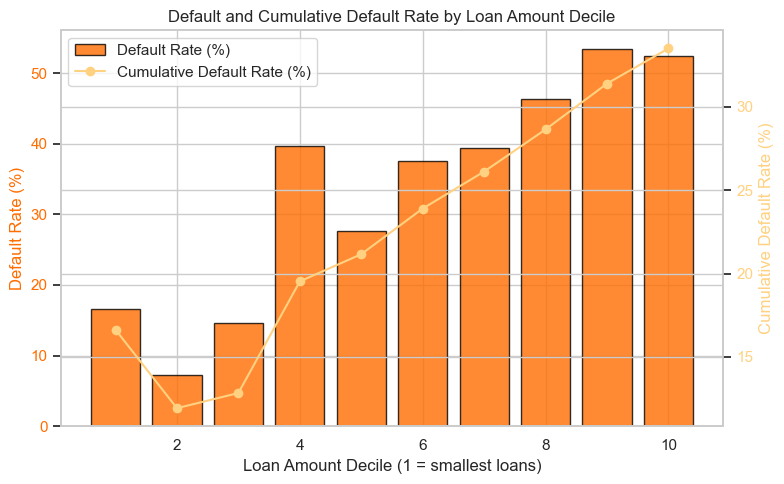

In [75]:
# Combined visualization: Default Rate and Cumulative Default Rate by Loan Amount Decile

# Set style
sns.set_style("whitegrid")

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar plot for default rate (primary y-axis)
bars = ax1.bar(
    decile_df['decile'],
    decile_df['default_rate'],
    color="#FF6D00",      # dark orange
    edgecolor='black',
    alpha=0.8,
    label='Default Rate (%)'
)

ax1.set_xlabel('Loan Amount Decile (1 = smallest loans)')
ax1.set_ylabel('Default Rate (%)', color="#FF6D00")
ax1.tick_params(axis='y', labelcolor="#FF6D00")

# Create secondary axis for cumulative default rate
ax2 = ax1.twinx()

# Line plot for cumulative default rate (secondary y-axis)
ax2.plot(
    decile_df['decile'],
    decile_df['cumulative_default_rate'],
    marker='o',
    linestyle='-',
    color="#FFD180",      # light orange
    label='Cumulative Default Rate (%)'
)

ax2.set_ylabel('Cumulative Default Rate (%)', color="#FFD180")
ax2.tick_params(axis='y', labelcolor="#FFD180")

# Title and layout
plt.title('Default and Cumulative Default Rate by Loan Amount Decile')
fig.tight_layout()

# Build combined legend
lines_labels = []
for ax in [ax1, ax2]:
    line, label = ax.get_legend_handles_labels()
    lines_labels += list(zip(line, label))

# Remove duplicates and show legend
handles, labels = zip(*dict(lines_labels).items())
ax1.legend(handles, labels, loc='upper left')

plt.show()


From the decile analysis, this 2% threshold is reached roughly within the top 3–4 deciles (the safest 30–40% of customers, i.e., lowest PDs / smaller, safer loans).<bt>

**Answer / Business recommendation**
- To achieve a portfolio cumulative default rate of around 2%, the business should accept only loans in the top 3–4 PD deciles (the lowest-risk 30–40% of customers).
- Loans in higher-risk deciles (5–10) should generally not be automatically approved; they can either be declined or offered only with tighter limits, higher pricing, or additional collateral to compensate for their higher risk.

#### 7. What are the characteristics of a defaulter and how important are they?

**From EDA and feature importance**

| Characteristic                               | Defaulter Trend                       | Importance |
| -------------------------------------------- | ------------------------------------- | ---------- |
| High avg_dpd                                 | Often late in multiple installments   | Very High  |
| Has previous default (n_defaulted_loans > 0) | Likely to re-default                  | Very High  |
| Worst SLIK score ≥ 4                         | History of 91+ days overdue           | High       |
| Low payment ratio (< 80%)                    | Under-payer behavior                  | High       |
| Short job tenure / unstable occupation       | Unstable income                       | Medium     |
| Single / Lajang                              | Less financial responsibility sharing | Low–Medium |

**Summary interpretation**

Defaulters typically:
* have a history of late or incomplete payments,
* show weak credit scores (SLIK 4–5),
* and often hold short-term or less stable employment types.

Such features carry high weight in Logistic Regression coefficients and drive the PD score.

---

### Assignment 6 - Further Improvement

If you have had more time, what would you recommend to further improve the model and why?


---

If more time were available, several enhancements could improve the model’s robustness and business reliability:

1. **Feature Refinement and Leakage Handling**
   * Reassess post loan behavioral variables (e.g., DPD, payment ratios) that cause **data leakage** and transform them into **proxy or summary features** available at the time of loan approval.
   * This can be handled internally by using early-cycle indicators (e.g., customer label or historical late payment counts) instead of removing data or requiring new sources.

2. **Model Calibration and Stability**
   * Calibrate probabilities (e.g., via Platt scaling or isotonic regression) so predicted PDs align with observed default rates.
   * Regularly track performance metrics (AUC, KS, recall) to ensure stability over time.

3. **Algorithm Enhancement**
   * Test non linear models such as LightGBM or CatBoost and compare against Logistic Regression for improved predictive power while maintaining interpretability.

4. **Threshold and Business Optimization**
   * Optimize the cut off threshold using **expected loss** or **profit-based** criteria rather than accuracy, aligning model outputs with business objectives.

5. **Explainability and Governance**
   * Incorporate SHAP-based interpretation to ensure transparency for risk and compliance review.

**Reasoning:**
These improvements would strengthen the model’s predictive validity without depending on new data sources.
By properly handling internal data leakage and refining calibration, the model can evolve into a **production ready credit scoring tool** that remains accurate, stable, and explainable.